In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
K_real = K_real[0:96,:]
Q_real = Q_real[0:96,:]
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = pi_real[:,0:96]

In [4]:
pi_real.shape

(150, 96)

In [5]:
len(K_real)

96

Text(0, 0.5, 'Remaining Trip Distance (miles)')

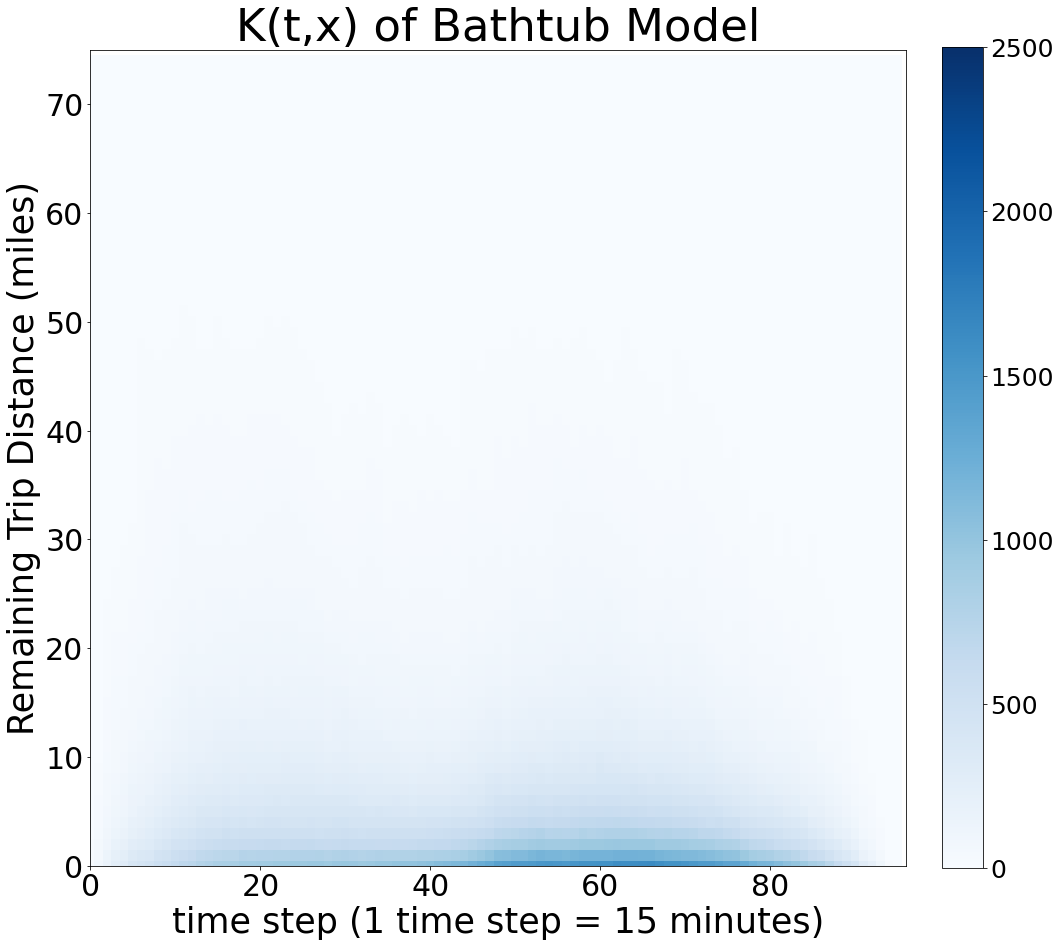

In [6]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,len(K_real),0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [7]:
## Scale
N_timestep = 24*1*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  95
usol max =  1627


In [8]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  1440
N_u =  288
N_f =  576


In [9]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [10]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [11]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [12]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [13]:
X_u_train.shape

(288, 2)

In [14]:
X_u_test.shape

(1152, 2)

In [15]:
X_u_train

array([[0.33783784, 0.71578947],
       [0.74324324, 0.47368421],
       [0.81081081, 0.21052632],
       [0.13513514, 0.27368421],
       [0.74324324, 0.30526316],
       [0.74324324, 0.97894737],
       [0.87837838, 0.10526316],
       [0.33783784, 0.22105263],
       [0.06756757, 0.47368421],
       [0.81081081, 0.48421053],
       [0.33783784, 0.75789474],
       [0.27027027, 0.29473684],
       [0.67567568, 0.31578947],
       [0.2027027 , 0.82105263],
       [0.54054054, 0.64210526],
       [0.54054054, 0.47368421],
       [0.2027027 , 0.71578947],
       [0.40540541, 0.06315789],
       [0.13513514, 0.06315789],
       [0.47297297, 0.49473684],
       [0.74324324, 0.76842105],
       [0.54054054, 0.96842105],
       [0.27027027, 0.56842105],
       [0.2027027 , 0.28421053],
       [0.33783784, 0.27368421],
       [0.06756757, 0.54736842],
       [0.87837838, 0.08421053],
       [0.06756757, 0.29473684],
       [0.2027027 , 0.42105263],
       [0.60810811, 0.4       ],
       [0.

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [16]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [17]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.012834904103753986 0.023482569485192575 0.0021872387223153961 0.8346863389745839
0.012575575239600604 0.023395422262172463 0.001755728217028744 0.8333377665237635
0.012361156006733352 0.023154156386447518 0.001568155627019185 0.8291339671141704
0.012121839841431725 0.022536191523036549 0.0017074881598269033 0.8178938362761798
0.011694145825694606 0.021028853211652258 0.0023594384397369553 0.7889347956660558
0.011341757965966934 0.019927872862017179 0.0027556430699166895 0.7661845286812018
0.011207380035272779 0.019527808626810569 0.002886951443734988 0.7573512427683347
0.011122310024598221 0.019421122162488876 0.0028234978867075662 0.7547469424982078
0.010991266488387467 0.019389106042887461 0.0025934269338874732 0.7534913297963599
0.010885563027098658 0.01935349758885704 0.0024176284653402739 0.7525558889889145
0.010817310155215962 0.019371633601096894 0.0022629867093350293 0.7529392553809124
0.010774157690091445 0.019347365666671081 0.0022009497135118089 0.7525143519009024
0.010639

0.0076144729305190548 0.01217445276216929 0.0030544930988688187 0.5979973463460787
0.0076060011420077678 0.012083875784395523 0.0031281264996200126 0.5957817983521028
0.0075981936237551062 0.012094488968990812 0.0031018982785194012 0.5959632064319345
0.00759332559318463 0.012122301717584725 0.0030643494687845347 0.5966443490031889
0.0075883177675577559 0.012192584703620422 0.0029840508314950905 0.5983244076140777
0.0075788398503159344 0.01226243577304866 0.0028952439275832078 0.6001819305766124
0.0075594836289236628 0.012366453619557122 0.0027525136382902031 0.6031427047093647
0.0075335548152746486 0.012371373270135471 0.0026957363604138257 0.6038524456196891
0.00748912530336214 0.012178666951717161 0.0027995836550071197 0.5998345026254106
0.00745552680349236 0.011841960203933778 0.0030690934030509426 0.5924295232760705
0.00742258530799831 0.011599762719742689 0.0032454078962539314 0.5871419037248661
0.0073899091670498957 0.011216071088694497 0.0035637472454052937 0.5783785949541396
0.

0.0058760258241270817 0.0085713592388799078 0.0031806924093742556 0.523982473800593
0.0058729071720355665 0.0085105621070511034 0.0032352522370200291 0.5227298090541828
0.0058706281698972058 0.008516348699098425 0.0032249076406959862 0.5228730154660799
0.0058693543742183328 0.0085078373505861789 0.0032308713978504867 0.5227213223967011
0.0058681841972279764 0.0084914253330632683 0.0032449430613926845 0.5223890056087561
0.0058652868347362783 0.00846489952294575 0.0032656741465268055 0.5218968956717213
0.0058598470415588974 0.0084144731212957066 0.0033052209618220879 0.5206360181205925
0.0058541911655619391 0.0084173692781602735 0.0032910130529636037 0.5217086066127076
0.0058467813685411686 0.0083809038143219088 0.0033126589227604288 0.5200105957385925
0.0058420590629794551 0.0084283074386599949 0.0032558106872989162 0.5212851802662664
0.0058360102468506675 0.00851876373683793 0.0031532567568634045 0.5237497498293837
0.0058317333909135528 0.0085271949530132014 0.0031362718288139046 0.523

0.0051927728979812432 0.0076825569520906955 0.0027029888438717914 0.4961970129601839
0.0051901391533184385 0.0076581621096060521 0.0027221161970308245 0.4953025806733141
0.005188500110270354 0.0076339396903093255 0.0027430605302313821 0.49467558564916886
0.005186929601533552 0.0076298650643649851 0.0027439941387021193 0.49441536192431246
0.0051838786650536131 0.0075989045601722515 0.0027688527699349752 0.4933832369199021
0.0051802198367392428 0.0075789236246948943 0.0027815160487835908 0.49268697177218546
0.0051731824555716795 0.0075410930319372172 0.0028052718792061413 0.49180009507133915
0.00516494729514778 0.0075002166675170396 0.0028296779227785208 0.4909096086973944
0.00515731390290961 0.007510358711753623 0.0028042690940655972 0.4916924937659979
0.0051541947921978212 0.0075519063030938171 0.0027564832813018253 0.4931712051437265
0.0051529895027740483 0.0075123370773281361 0.0027936419282199604 0.49174359554723573
0.0051526935920251406 0.00749494327708795 0.0028104439069623309 0.4

0.0046362845935571245 0.0076421653659387674 0.0016304038211754817 0.4944059904760253
0.0046339517293576341 0.0076275733604993052 0.0016403300982159627 0.4939379176651642
0.00463247078948986 0.0076182488814886245 0.0016466926974910959 0.49368932786448255
0.0046304168371678611 0.00761071037346154 0.001650123300874182 0.49352953702088787
0.0046285400804155557 0.007609891629382603 0.0016471885314485091 0.49347169113889194
0.004626443639742463 0.0076191652435689972 0.0016337220359159286 0.4939950825727618
0.004624088366618582 0.0076135611394174052 0.0016346155938197588 0.4939949571912509
0.0046195308325659044 0.0076089008050666367 0.0016301608600651721 0.4945841877760136
0.0046143042088000906 0.00758398704563794 0.0016446213719622407 0.49458217894729983
0.0046106014483610633 0.0075734190347004314 0.0016477838620216952 0.4946756222876499
0.0046082029503276695 0.0075757020160927184 0.0016407038845626196 0.49478248074257986
0.0046062863348534872 0.0075841025223395992 0.0016284701473673747 0.49

0.0043741771638927127 0.0067425670623162438 0.0020057872654691811 0.4840136429284666
0.004373526434357667 0.0067415664652831567 0.0020054864034321773 0.4841019928254306
0.0043726074853726333 0.0067362449943299731 0.0020089699764152926 0.4840549885213961
0.004371309071206292 0.0067234267429920284 0.0020191913994205557 0.48392270381019126
0.0043674533165354232 0.006694917329408346 0.0020399893036625004 0.4835872130585138
0.0043623603954723337 0.006651807534523789 0.0020729132564208789 0.48292162090093815
0.0043543508145607295 0.0066262217745582091 0.0020824798545632508 0.48264770808226853
0.0043504196197467039 0.0066045509846759682 0.0020962882548174393 0.48204692756660844
0.00434452769100889 0.00661465206841231 0.0020744033136054687 0.4821697669945299
0.004341457217178428 0.0065629426312316151 0.00211997180312524 0.4806452215648639
0.0043384132129520086 0.0065527006421536938 0.0021241257837503235 0.48016734153612706
0.0043353331360990732 0.006520617930706258 0.0021500483414918885 0.4784

0.0039524359889578746 0.005751607079456056 0.0021532648984596936 0.4723819670441002
0.0039463203166230582 0.0057610398094215167 0.0021316008238246 0.472718729678724
0.0039438444503066428 0.0057722791565822081 0.0021154097440310767 0.4728433510152692
0.0039393501214550408 0.0057753871370361809 0.0021033131058739007 0.4728879861964674
0.0039355179222409185 0.0057303755977469043 0.0021406602467349337 0.47164802507582615
0.003932189419126121 0.0057091271327179855 0.0021552517055342568 0.47121963691692853
0.0039234242399203822 0.0056556697067620459 0.002191178773078718 0.4697269704877017
0.0039174877253406043 0.0055768659496222 0.0022581095010590097 0.46788202732486717
0.0039123242704145016 0.00556638146772179 0.0022582670731072126 0.467663809761481
0.0039086940197899864 0.0055992008235382883 0.0022181872160416836 0.46838276425134523
0.0039042243575326762 0.005615977153909703 0.0021924715611556494 0.46869673919966853
0.0038976790457997817 0.0055997332011810293 0.0021956248904185347 0.468523

0.0035591850068526915 0.0051617598029338359 0.0019566102107715475 0.47123519750465953
0.0035573190618162862 0.0051491796346784394 0.0019654584889541326 0.4706825517585764
0.0035551925507946391 0.005145014924893246 0.0019653701766960321 0.47038696144705533
0.0035516315963368961 0.0051431290732657951 0.0019601341194079975 0.4700951407428895
0.0035482236098755915 0.0051522123358852985 0.0019442348838658848 0.4702419206074488
0.0035451026966082338 0.0051637156265911524 0.0019264897666253151 0.47054264090315967
0.003542862745894194 0.0051847958604988092 0.0019009296312895788 0.47117587047260207
0.003540136103646699 0.0051827479655699431 0.0018975242417234547 0.4713076932251003
0.0035376495177373963 0.0051817102514812689 0.0018935887839935234 0.47151440136504974
0.0035367637193703463 0.0051982638177034317 0.0018752636210372612 0.47196384066346936
0.0035350516080302906 0.0051873594997871768 0.0018827437162734042 0.47173465278464155
0.003533928998392076 0.0051877330631366347 0.0018801249336475

0.0031813217281418385 0.00478332273233465 0.0015793207239490265 0.4617006488692386
0.0031799049458156327 0.0047500976707975312 0.001609712220833734 0.4603250114052432
0.0031780202278497952 0.0047615831391630108 0.0015944573165365798 0.460764371014701
0.0031764209047932092 0.0047732689722753564 0.0015795728373110623 0.4611392540904585
0.0031728702499424144 0.0047958116878722189 0.0015499288120126103 0.4618987585996057
0.0031688755901565879 0.004822208676986732 0.0015155425033264436 0.4628685580210302
0.003166855253350899 0.004829142809243449 0.0015045676974583489 0.46300598620726324
0.0031625248141111911 0.0048404199211825264 0.0014846297070398556 0.4632594229885374
0.0031573034808064235 0.0048377782956172581 0.0014768286659955884 0.46303352798833836
0.0031520453871062689 0.0048224134756495026 0.0014816772985630357 0.46249807030032386
0.0031483324977288449 0.0048122035522142875 0.0014844614432434021 0.46221239434288497
0.003146430926705425 0.004808365384314367 0.0014844964690964833 0.46

0.002816393151802184 0.0042046893775256645 0.0014280969260787031 0.43457403040624487
0.0028113913976288 0.0041945831393102873 0.0014281996559473125 0.4343815530472507
0.002808326461773827 0.0041786245347378856 0.0014380283888097681 0.4337943556719912
0.002801461144368226 0.0041757447753922967 0.0014271775133441553 0.4339418425960696
0.0027968417164589768 0.0041458801807342065 0.0014478032521837475 0.43249880578958866
0.0027924015489610363 0.0041149741764173091 0.0014698289215047636 0.4314629627250327
0.0027890079745194452 0.0040871619332939792 0.001490854015744911 0.42975581999851886
0.002784951241237392 0.0040812377945601257 0.001488664687914658 0.4287955939916382
0.002778898462308544 0.0040588190584317889 0.0014989778661852989 0.4275817101651274
0.0027757603429269247 0.00402256889094681 0.001528951794907039 0.426051342619719
0.0027707039278437782 0.0040369246192637947 0.0015044832364237617 0.42741371473326095
0.0027647942953444842 0.0040441528861266569 0.0014854357045623113 0.4278458

0.0023725729542848767 0.0036936970625131311 0.0010514488460566221 0.4092083654168183
0.0023713513641380152 0.0036942296431407861 0.0010484730851352442 0.40915109545075723
0.0023694742534908298 0.0036941045933137043 0.0010448439136679557 0.4091051668790417
0.0023672017030003461 0.0036903402604232497 0.0010440631455774425 0.40885103004467943
0.0023651259327223655 0.0036898529358158657 0.0010403989296288649 0.409139820689784
0.0023630243633461175 0.0036856133246450113 0.0010404354020472236 0.40883328428005855
0.0023605247393050062 0.0036837831487353378 0.0010372663298746747 0.40878529566286564
0.0023590314735338373 0.0036889337561979065 0.0010291291908697676 0.40921198535891834
0.0023582158726414117 0.0036898090292212388 0.0010266227160615842 0.4093071833360841
0.0023571919350526462 0.0036898671605212841 0.0010245167095840081 0.40918130728543955
0.0023566708131528297 0.003691527276437968 0.0010218143498676915 0.4092705414805656
0.0023562114748513908 0.0036915675996292787 0.001020855350073

0.0022893933339934954 0.0035374454248693135 0.0010413412431176771 0.3998184218633361
0.002288791922913559 0.0035356019493742266 0.0010419818964528915 0.40003322185942697
0.0022883837741147998 0.0035374959859345747 0.0010392715622950248 0.4000286913039826
0.0022881648339490067 0.0035347208638587652 0.0010416088040392484 0.39991607165192383
0.0022877557952504161 0.00353135249656311 0.0010441590939377226 0.39989653423849875
0.0022872516577412136 0.0035271706402703945 0.0010473326752120328 0.3998576580213478
0.002286229907889984 0.0035236550845224018 0.0010488047312575664 0.3998720618482714
0.0022848473084567333 0.0035256754326890385 0.001044019184224428 0.4001974745635666
0.0022841609260635994 0.0035289917483489535 0.0010393301037782457 0.40047434328419285
0.0022833205838561719 0.0035393344423777537 0.00102730672533459 0.4008551513711194
0.0022820930866324272 0.00354398957850607 0.0010201965947587847 0.4012445473583902
0.0022813724965399245 0.0035434223675437238 0.0010193226255361249 0.40

0.0022296472372767889 0.0035253721996882925 0.0009339222748652857 0.4045141324237869
0.0022294963112685757 0.003526692141614701 0.00093230048092245014 0.40454168257745193
0.0022294192249097708 0.0035265467672093609 0.00093229168261018032 0.40443283760109816
0.0022292571584549051 0.0035269370565047262 0.00093157726040508373 0.4045025474089262
0.0022291198815847292 0.0035270744782614958 0.00093116528490796221 0.4046611338803783
0.0022289774359582262 0.003525638236307737 0.000932316635608715 0.40483129970346665
0.0022288907544766113 0.0035242203317784552 0.00093356117717476733 0.40498223517141535
0.002228825659846603 0.003522169385894084 0.000935481933799122 0.4050634519808159
0.0022287680769412649 0.0035208685410003013 0.00093666761288222888 0.4051313373242896
0.0022286771078056083 0.0035191802244846923 0.00093817399112652465 0.4051465688229165
0.0022285218719641816 0.0035180954862611105 0.00093894825766725255 0.40518164856595035
0.0022282416392569713 0.0035162782236477516 0.000940205054

0.0021662175132732037 0.0034533603341316923 0.00087907469241471506 0.40545620829835616
0.0021655598326545582 0.0034538401558997386 0.00087727950940937787 0.4056268555996314
0.0021646993425715106 0.003454263591418327 0.00087513509372469421 0.40573176550659856
0.0021636700235005768 0.0034580696149087795 0.00086927043209237393 0.4059592740130715
0.0021623633326650978 0.0034571214000404873 0.00086760526528970787 0.40609779766908366
0.0021622245054786875 0.00345719453273621 0.000867254478221165 0.40588732350646606
0.00216082157784256 0.0034594332036605247 0.00086220995202459583 0.405999236305473
0.0021601144283968947 0.0034634078143219314 0.00085682104247185743 0.40631616951928984
0.0021598147619673546 0.0034638459578290146 0.00085578356610569437 0.40644261096942336
0.0021594780187879788 0.0034673216641959159 0.00085163437338004193 0.40659740689556534
0.0021591988395874085 0.0034670975688083677 0.00085130011036644931 0.4064165619751246
0.0021590091617323661 0.0034670575281949357 0.000850960

0.0021358690813631505 0.0033770794244731973 0.00089465873825310329 0.4043361135591454
0.0021356519939399157 0.0033756217354240347 0.00089568225245579669 0.40439207477334504
0.0021352862565352372 0.0033699669621485217 0.00090060555092195287 0.40439963103963883
0.002135201126270447 0.003359612889182653 0.0009107893633582407 0.4040089000889198
0.0021346791485393041 0.0033582291259070976 0.00091112917117151056 0.4044213742669378
0.0021343367355592452 0.0033607769263261917 0.00090789654479229856 0.4046695326999125
0.0021336906780809644 0.0033595587023917562 0.00090782265377017241 0.4047734692816734
0.002133136700338482 0.0033635176206003236 0.0009027557800766401 0.404866159629641
0.0021327802350826108 0.0033595216168700783 0.00090603885329514305 0.4048576663387131
0.0021319444225338983 0.0033617624645679925 0.00090212638049980425 0.4050759686610632
0.0021318584123417254 0.00336489270936942 0.00089882411531403122 0.40548679598247617
0.0021312608487223357 0.0033651036339597067 0.0008974180634

0.0020992093746455315 0.003353520558697361 0.00084489819059370224 0.40388186591384767
0.0020988793963824569 0.0033525082779340895 0.00084525051483082389 0.4038848959779295
0.0020983089637146473 0.0033515177266219814 0.00084510020080731327 0.4034872809548302
0.0020976926104208315 0.003350917200889461 0.00084446801995220213 0.40316937200682845
0.002096982424032944 0.0033484346609677731 0.00084553018709811493 0.4021339971029453
0.002096113403450485 0.0033435168182088496 0.00084870998869212015 0.4018375574469757
0.0020954324446706891 0.0033401703334529314 0.00085069455588844675 0.4015056729404837
0.0020946075376499021 0.0033398432496282082 0.00084937182567159579 0.40073109598327966
0.0020939293040224314 0.0033386903344390958 0.0008491682736057666 0.4009309095916201
0.0020936955605630626 0.0033370384648471738 0.00085035265627895129 0.4006778595669201
0.002092706637477953 0.0033383165949598176 0.00084709667999608839 0.40024148639729484
0.002092146759278225 0.0033344104398249203 0.00084988307

0.0020745664945923444 0.0033284933152236424 0.00082063967396104687 0.4063908972399657
0.0020744797529673726 0.0033336880908364369 0.00081527141509830871 0.4067162169772492
0.002074398594304624 0.003332976994810373 0.00081582019379887482 0.40683114079917526
0.0020743130151042329 0.0033311855071731043 0.00081744052303536145 0.406842131845356
0.0020741938929275177 0.0033302397727133642 0.0008181480131416709 0.40691303102176996
0.0020740154943920475 0.0033305645804089542 0.00081746640837514109 0.4072545858935667
0.0020739980099259763 0.003327778698223525 0.0008202173216284277 0.40728563363612763
0.0020738952972980812 0.0033271041492610371 0.00082068644533512484 0.40725627879005855
0.0020738244447464534 0.0033291219588600972 0.00081852693063280951 0.4074981680375701
0.0020736909655160929 0.0033297528960257888 0.00081762903500639649 0.4073579542287564
0.0020735875782984612 0.0033297199397070115 0.00081745521688991068 0.40744205361083463
0.0020734745259592745 0.0033299521955583761 0.000816996

0.002058184477227382 0.0032985645698017569 0.000817804384653007 0.4062788068717397
0.0020581309518067823 0.0032981858488083889 0.00081807605480517574 0.40626945103704115
0.00205808217267026 0.0032981251805586664 0.00081803916478185364 0.40623204183556877
0.0020580361149505587 0.0032984900024667719 0.00081758222743434552 0.4062241891710988
0.0020579992918222986 0.0032987945715210803 0.0008172040121235169 0.40618107082075733
0.00205797535096219 0.0032994104966297989 0.00081654020529458118 0.40618966290516567
0.0020579534315944606 0.0032991651631899634 0.00081674169999895805 0.40619546207272356
0.0020579243121154555 0.003299462345197921 0.00081638627903298986 0.4062443573778728
0.0020579090264942687 0.0032986317944110675 0.00081718625857746946 0.40625288743546584
0.0020578636939308946 0.0032984320346854095 0.00081729535317637985 0.4063354707943492
0.0020578350378685963 0.0032974653057589328 0.00081820476997825954 0.4062841799374506
0.0020578019688005391 0.0032962886914532264 0.00081931524

0.0020289636795066792 0.0032412717923094476 0.00081665556670391113 0.4109444957019426
0.0020287302316766447 0.0032426737974188841 0.00081478666593440534 0.4108700391927866
0.0020283575344393514 0.0032436797657587127 0.00081303530311998987 0.4108103061858465
0.0020280204967745769 0.0032438360202708938 0.00081220497327826 0.41093744359409984
0.0020277117284782597 0.0032437392823335891 0.00081168417462293028 0.41099220416135684
0.0020275479260815086 0.0032425379479522486 0.00081255790421076886 0.4110585352717759
0.0020274499270718188 0.0032424973170899467 0.00081240253705369052 0.41088607302927965
0.0020273423479915532 0.003242172919969167 0.00081251177601393955 0.41077906032186173
0.0020272288283517577 0.00324246210870191 0.00081199554800160507 0.41065561731913314
0.0020272038218314622 0.00324186537593258 0.00081254226773034492 0.410617286487699
0.0020270673926370279 0.0032417128925396055 0.00081242189273445019 0.41050440096444907
0.0020268705635476465 0.0032429866351883605 0.00081075449

0.0019921771357118527 0.0031589649598228278 0.00082538931160087753 0.41587689608447237
0.001992078739301067 0.0031598241648981072 0.00082433331370402663 0.416010572184059
0.0019918327197995336 0.0031617392773880381 0.00082192616221102917 0.4164797911283651
0.0019916648602608528 0.0031625909676618164 0.000820738752859889 0.41672460585865595
0.0019914648533120149 0.0031620801238970448 0.00082084958272698452 0.41702606291971445
0.0019912650329452016 0.00316018547186555 0.0008223445940248532 0.4170999623096153
0.001991148615401513 0.0031569867371085362 0.00082531049369449 0.4169382113789551
0.0019909928772004304 0.0031558003357570895 0.000826185418643771 0.4167024016740969
0.0019908819474992018 0.0031553344612126281 0.00082642943378577569 0.41677161740498386
0.0019907240996375436 0.0031539180920862591 0.00082753010718882806 0.416650129188238
0.0019905142485174424 0.0031518325002796552 0.00082919599675522948 0.4166160734766696
0.001990330832521728 0.0031534525261486921 0.0008272091388947642

0.001946662047084372 0.0031254115311948483 0.00076791256297389563 0.41415605947100653
0.0019464387074255335 0.0031231437069333548 0.00076973370791771206 0.41394437677118295
0.0019463482281251005 0.0031206659448421471 0.00077203051140805386 0.41361091808121286
0.0019462806614422858 0.0031195310966622581 0.00077303022622231341 0.413437162328654
0.0019462096477422723 0.00311909374137845 0.00077332555410609494 0.4132674508685059
0.0019461286957106329 0.0031189481080673865 0.00077330928335387922 0.4131942782724543
0.0019460518388381089 0.0031193035409801863 0.00077280013669603148 0.41320434502685127
0.0019460372953384996 0.0031193589044470893 0.00077271568622991013 0.4132093963432591
0.0019459918538096788 0.0031194923302760944 0.000772491377343263 0.4133174635194573
0.0019459149635777369 0.0031193052260856061 0.00077252470106986754 0.41328563675711455
0.0019458240332001966 0.0031201192790239682 0.00077152878737642475 0.41335320270947196
0.0019457889029675557 0.0031223572076777375 0.00076922

0.0019089916762697781 0.0030663390177236159 0.00075164433481594026 0.40733883349441036
0.001908667378794577 0.0030644247670453925 0.00075290999054376166 0.4073790612500466
0.001908362631681689 0.0030643838398597195 0.00075234142350365837 0.4073854636849882
0.0019082931501338885 0.003066116709196539 0.0007504695910712381 0.4074480396868368
0.0019079163060626524 0.0030665787388524284 0.0007492538732728765 0.4074049429058155
0.0019074706220538655 0.0030648820883316086 0.00075005915577612266 0.40721753178308817
0.0019070096793288751 0.0030618308690818375 0.00075218848957591278 0.4069852918837461
0.0019065844306039386 0.0030593054672657704 0.000753863393942107 0.4067737322578211
0.00190610164981013 0.0030559298782010642 0.000756273421419196 0.40649045139704965
0.0019058592464675013 0.0030512538578742481 0.00076046463506075472 0.4064173407562774
0.0019049799335077592 0.0030524296769414735 0.00075753019007404479 0.4064226526221601
0.0019044290503089608 0.0030573518135235938 0.0007515062870943

0.0018535181857488115 0.00302825604497693 0.00067878032652069268 0.40320491753573295
0.0018530573770740833 0.0030292138626626824 0.00067690089148548431 0.4038167355090628
0.0018528521550763729 0.0030324582107305125 0.00067324609942223332 0.4047435107754484
0.0018527680133472735 0.0030356434829117481 0.00066989254378279879 0.40527985966147373
0.0018522983916728977 0.0030328826912133168 0.00067171409213247853 0.40489716299094214
0.0018520624326970694 0.0030321000091040554 0.00067202485629008345 0.40454245855766896
0.0018518572747344949 0.0030318904985907709 0.000671824050878219 0.40473915878031436
0.001851536207336748 0.0030303310358477543 0.000672741378825742 0.404730822113278
0.001851199456034273 0.0030256416379558244 0.00067675727411272161 0.404344440500189
0.0018511204018575461 0.0030269020089120284 0.0006753387948030638 0.404327293489269
0.0018509529079049764 0.0030240365708133331 0.00067786924499661967 0.40392230608142254
0.001850752407655074 0.0030229791138899759 0.000678525701420

0.0018120815652126815 0.002978913486591071 0.000645249643834292 0.40017442077492904
0.0018114821609390103 0.0029807070537410333 0.00064225726813698725 0.39986713486723463
0.0018109624698176205 0.0029813209823618468 0.00064060395727339413 0.40003144885572245
0.0018104949327098253 0.0029813024551592297 0.00063968741026042112 0.4003841543307373
0.0018098858147453411 0.0029812289707544281 0.000638542658736254 0.4006469516083859
0.0018095347565571598 0.0029806360640972124 0.00063843344901710712 0.4010376172821621
0.0018091164322728214 0.0029787983790471816 0.00063943448549846113 0.40079985731222567
0.0018087196027717464 0.0029792542324585032 0.00063818497308498984 0.4007046918608308
0.0018082478849274835 0.0029773551567982125 0.0006391406130567543 0.40057565880261947
0.0018077608453884982 0.0029731894526267783 0.0006423322381502182 0.40031146656722266
0.0018073388192220859 0.0029700337743258551 0.00064464386411831659 0.4004668215865361
0.001807015946131617 0.0029683422580001643 0.0006456896

0.0017798920270405644 0.0029367477802710643 0.00062303627381006456 0.3993783062695647
0.0017795752755744385 0.0029396053841297832 0.00061954516701909364 0.39922308325044165
0.001779232313602301 0.0029419266972561349 0.0006165379299484672 0.3993223456459467
0.0017788134955412376 0.0029425050139383862 0.00061512197714408878 0.39945855868660585
0.0017784430779791214 0.0029414853313752976 0.00061540082458294511 0.39938916530104673
0.0017778895259606541 0.0029388956264249848 0.00061688342549632354 0.3994215087710294
0.0017773566207582455 0.0029371105221733095 0.00061760271934318146 0.3993159220804027
0.0017766164763922303 0.0029347451924678514 0.0006184877603166094 0.3993653594104224
0.0017756390914382954 0.002930835206862924 0.00062044297601366661 0.3989223324126837
0.0017750691829654698 0.0029284914934165013 0.00062164687251443831 0.39886027792858203
0.00177459445436617 0.0029273992428534897 0.00062178966587885019 0.3987126471684672
0.0017740140071082189 0.0029276207152360589 0.0006204072

0.001751062579871538 0.0029422890891573988 0.00055983607058567714 0.39828928586972995
0.0017510178172822589 0.0029429390797186907 0.000559096554845827 0.3984017183268557
0.0017509576268145719 0.0029420450272211896 0.00055987022640795409 0.39838288406646755
0.001750905244254107 0.0029414655740071052 0.00056034491450110879 0.398441562248774
0.0017508284880836966 0.0029413598620526382 0.00056029711411475494 0.39845210837698963
0.0017508146637843377 0.0029410812299184288 0.00056054809765024641 0.3984736299421047
0.0017507254095097194 0.002941267234029103 0.00056018358499033559 0.3984984714783891
0.0017506619213071093 0.0029415924636833238 0.000559731378930895 0.39842741713787067
0.0017506085045222077 0.0029410247383614093 0.00056019227068300611 0.398405990989835
0.0017505621174490581 0.002940633891602506 0.00056049034329561 0.398356816547476
0.001750507245996305 0.0029396624608664956 0.00056135203112611459 0.398327826979582
0.0017504587372222326 0.0029400156090006267 0.0005609018654438386 

0.0017307732881420798 0.0029248526688078614 0.00053669390747629786 0.40185912389765516
0.0017297423759021944 0.0029231782285606212 0.00053630652324376761 0.40195849587563975
0.0017288448492136241 0.0029239422200311241 0.000533747478396124 0.4025311669342985
0.001728140880737567 0.002922835049112902 0.00053344671236223184 0.4030622829150226
0.0017277010158908022 0.0029260091782385678 0.00052939285354303655 0.40424072217708307
0.0017270092587645574 0.0029219443115459116 0.000532074205983203 0.40387273909274735
0.0017269567961103779 0.0029194183035443797 0.000534495288676376 0.40304370339539897
0.0017263518823242311 0.002919307674990464 0.00053339608965799815 0.40330498838586826
0.0017260938316823252 0.0029185799568197486 0.00053360770654490176 0.4034524975935887
0.0017257943499818518 0.0029194083492717154 0.00053218035069198808 0.4033445013395506
0.0017251609963085182 0.0029172815435989288 0.00053304044901810756 0.4026239884306557
0.0017249323479846714 0.0029207937240428011 0.00052907097

0.0017061749007487575 0.0029189681180013063 0.00049338168349620862 0.40853123347706044
0.0017059935593661544 0.0029211330802217089 0.00049085403851060008 0.40844328574206723
0.001705826833771192 0.0029220490668452948 0.00048960460069708922 0.4084116660717764
0.0017056659168404402 0.0029211519889459398 0.00049017984473494083 0.4082012993279077
0.0017055826237640502 0.0029219739217202861 0.00048919132580781447 0.40813944858546997
0.0017054195965418458 0.0029213740141781127 0.00048946517890557885 0.40829657039747136
0.0017051542048935535 0.0029209896143394649 0.0004893187954476422 0.4082647812706515
0.0017049547132778192 0.002920845007223219 0.00048906441933241947 0.4083883999675274
0.0017048527406055979 0.0029204988367664921 0.00048920664444470372 0.4083973688638513
0.0017047380602144202 0.0029190248889901255 0.00049045123143871491 0.40838980840523065
0.001704649721147781 0.0029175675927260872 0.00049173184956947458 0.4083467575948356
0.0017045694559992817 0.0029168053088306244 0.0004923

0.0016927342363227231 0.0028961611538844897 0.00048930731876095624 0.404449596735042
0.0016926051622997628 0.0028954399516541063 0.00048977037294541939 0.40449666310020843
0.0016924745445935396 0.0028946142033451274 0.00049033488584195159 0.4045412410440147
0.0016922111812533022 0.0028935626353010224 0.000490859727205582 0.40441842742661993
0.0016919654871091832 0.0028918483599156292 0.00049208261430273728 0.4043179869567649
0.0016916980848906567 0.0028914546911734426 0.00049194147860787086 0.4038265284923344
0.0016912756042067468 0.0028911692367607042 0.00049138197165278931 0.4039151641356137
0.0016907852442924814 0.0028886903594086627 0.0004928801291763 0.4037991983799168
0.0016905636090651095 0.0028877060651387437 0.00049342115299147525 0.40365660071027093
0.0016902455727648507 0.0028885421866138008 0.00049194895891590054 0.40353945426945953
0.0016899454900531378 0.002888644267967401 0.00049124671213887443 0.40342132457264523
0.0016896381843675735 0.002888609838481894 0.000490666530

0.0016751092678298637 0.002860333440484098 0.00048988509517562933 0.40591280720375883
0.0016750173330239092 0.0028615613193813724 0.0004884733466664461 0.406002413395125
0.0016748928990519241 0.0028636697598759292 0.00048611603822791907 0.40606886087574223
0.0016748187062771433 0.0028642611827234981 0.00048537622983078871 0.4062798940364369
0.001674660943140151 0.0028626230855856912 0.00048669880069461086 0.40617817089839814
0.001674587610261213 0.0028625055458727472 0.00048666967464967896 0.4062076094874507
0.0016744967943755904 0.002861612652523922 0.00048738093622725879 0.4062200625720824
0.0016743880330943 0.0028602570860791774 0.00048851898010942283 0.40634068194236894
0.0016742709857691593 0.002859771392789312 0.00048877057874900664 0.40642591360623903
0.0016740559090368946 0.0028596969935058905 0.00048841482456789883 0.4067281784692216
0.0016739734334956125 0.0028590338346663907 0.00048891303232483432 0.40690881002913987
0.0016737373258807599 0.0028596290191007 0.000487845632660

0.0016614727828310211 0.0028524684941432033 0.00047047707151883904 0.4066902932878327
0.0016613712951597834 0.0028511803019634157 0.00047156228835615105 0.40663446793082253
0.0016612403992619913 0.002851087317075918 0.00047139348144806465 0.40659196990271934
0.0016611169906853207 0.0028503899614714316 0.00047184401989920974 0.40650487592997775
0.001660974867360096 0.0028491329019191707 0.00047281683280102148 0.406391078770622
0.0016607905561582994 0.0028496021891846347 0.00047197892313196411 0.40641860399279484
0.0016605462879502007 0.0028471093290939518 0.0004739832468064496 0.4062632517834904
0.0016604007472196217 0.0028490446878335486 0.00047175680660569493 0.40670136695398745
0.0016601887027863544 0.0028485059009031861 0.0004718715046695226 0.40658985035309064
0.001660067173986127 0.002848779504777701 0.00047135484319455308 0.406548979972839
0.0016598964326772579 0.0028498292078866379 0.000469963657467878 0.40656664410604126
0.0016597090890172652 0.0028498422195254885 0.00046957595

0.0016476477935168437 0.0028557619402428134 0.00043953364679087388 0.4082003355461751
0.0016475926913944857 0.0028560659263495666 0.00043911945643940469 0.40832355584096464
0.0016475585907723635 0.0028561403973820119 0.00043897678416271495 0.4083980805206205
0.0016475134098318464 0.00285591721410154 0.00043910960556215291 0.40846285757130224
0.001647474008244173 0.0028554504964298194 0.00043949752005852653 0.40846783915593204
0.0016474450204259973 0.0028550377427903947 0.00043985229806159972 0.4084806765681395
0.0016474352892708289 0.0028550456599384291 0.00043982491860322892 0.4084845118981653
0.001647405279177282 0.0028547832107072616 0.00044002734764730239 0.40848282352946225
0.00164736675063072 0.0028548908388173946 0.0004398426624440456 0.4085064609544262
0.0016473530279396047 0.0028553293163607772 0.000439376739518432 0.40857159549099503
0.0016473323756817405 0.0028553080154891507 0.00043935673587433029 0.40852733486212917
0.0016472649272290831 0.0028561802250678171 0.00043834962

0.0016400799021320522 0.0028405495475877767 0.000439610256676328 0.406335604933065
0.0016399913858082637 0.0028395215081890727 0.00044046126342745488 0.40631770729265126
0.0016399152960737272 0.0028385928664425258 0.0004412377257049288 0.4063189908985553
0.0016398547354439415 0.0028378885937251751 0.00044182087716270786 0.40632675206166535
0.0016397900879067803 0.0028379902052205683 0.00044158997059299236 0.406310562135695
0.0016397029920777366 0.0028381043959678377 0.00044130158818763581 0.4063146620284584
0.0016396245941867442 0.0028374322401972609 0.00044181694817622757 0.4062603439788866
0.0016394856474976067 0.0028373807700972308 0.00044159052489798289 0.40639441425053285
0.0016392654004107811 0.0028333580588113107 0.00044517274201025155 0.40624153352707454
0.0016390153549457939 0.002832357181781989 0.00044567352810959853 0.40624499837755035
0.0016386860268808444 0.0028315532498626624 0.00044581880389902656 0.4066077348302018
0.0016385023333505713 0.0028330640253798837 0.000443940

0.0016299035221005048 0.0028111999479655428 0.00044860709623546665 0.4128723384133788
0.0016298437627405549 0.0028112626479047157 0.00044842487757639415 0.412929718988917
0.0016297977492378288 0.0028114460372659421 0.00044814946120971561 0.4130101538709861
0.0016297308929849952 0.0028119135015018471 0.00044754828446814352 0.4132729974170727
0.0016296881834786834 0.0028124035060137775 0.00044697286094358911 0.41332505638455
0.001629627011715725 0.0028118789535979565 0.00044737506983349328 0.41342324386892876
0.0016295715698612721 0.0028114861277244987 0.00044765701199804542 0.4134725738021848
0.0016295057878742806 0.0028110193937214184 0.00044799218202714279 0.41350558652359487
0.0016294606257544527 0.0028109471079315216 0.000447974143577384 0.4135642659016544
0.0016294149798894938 0.0028111845588864198 0.00044764540089256777 0.4136320012964806
0.0016293771704587808 0.0028117670407131921 0.00044698730020436937 0.4137591208027959
0.0016293402346693217 0.0028122022151354717 0.000446478254

0.0016238897595194876 0.0028151777695143193 0.000432601749524656 0.4143999937287048
0.0016238519063344532 0.0028156962502776366 0.00043200756239126982 0.41441563891581623
0.0016237984239237291 0.0028162500329590168 0.00043134681488844138 0.4144934882351831
0.0016237903815218256 0.002815925548726689 0.00043165521431696226 0.41451776114026256
0.0016237165435833184 0.0028157516610735111 0.0004316814260931259 0.4144659010051884
0.0016236141681494317 0.0028152368403112802 0.00043199149598758304 0.41453258898025847
0.001623565855718323 0.0028156949123385338 0.00043143679909811244 0.4144633355622217
0.0016234734294346986 0.0028158386270861293 0.00043110823178326785 0.4145287410652001
0.0016233579904230318 0.0028162876281903415 0.000430428352655722 0.41460492602703525
0.0016232746636564974 0.0028165857532031252 0.00042996357410986951 0.41459261142055015
0.0016231396478113115 0.0028178691369540746 0.00042841015866854841 0.41464075321284605
0.0016230308464451227 0.0028181273853473232 0.000427934

0.0016152246162824872 0.0028096283914332484 0.00042082084113172587 0.4142132527884558
0.001615176072564569 0.0028090638524415896 0.00042128829268754848 0.41416735290225964
0.0016151342325637506 0.0028081403873372233 0.00042212807779027788 0.4140801449204725
0.0016150969829410904 0.0028077641379882323 0.00042242982789394827 0.41410015339701145
0.0016150499871627889 0.0028075356759150174 0.00042256429841056032 0.4141606025765174
0.0016150371696252008 0.0028074872211758264 0.00042258711807457533 0.41403982954727553
0.0016149814233911851 0.0028076358429713752 0.0004223270038109951 0.41413933684628307
0.0016149530573976161 0.0028077506606968123 0.00042215545409842007 0.41413701788317187
0.0016149214572785714 0.0028075203752168892 0.0004223225393402536 0.41418887873466825
0.0016148703054429704 0.0028070591491376373 0.00042268146174830371 0.41425027096022893
0.0016147965021368451 0.00280632803927584 0.00042326496499785053 0.4144290476969744
0.0016147099414290378 0.0028049834251453812 0.000424

0.0016107979208816402 0.00280670875920992 0.0004148870825533607 0.415811332451551
0.0016107606782728944 0.002806268595215411 0.00041525276133037766 0.4158131723743032
0.0016107111144867214 0.0028060429142179604 0.00041537931475548265 0.41588525060701864
0.0016106820236723622 0.0028046682586912505 0.00041669578865347414 0.4158044680448615
0.0016106353141406339 0.0028049516059667863 0.00041631902231448154 0.41581284170355487
0.0016105901299106741 0.0028053257606307411 0.00041585449919060715 0.4158521994260408
0.0016105486115089824 0.0028053304364993115 0.00041576678651865335 0.4158699148750276
0.0016104981582686125 0.0028049853427040126 0.00041601097383321261 0.4158812370098071
0.0016104334348073996 0.0028047123368756203 0.0004161545327391789 0.41591328665172184
0.0016103583139117457 0.0028041967194333602 0.00041651990839013087 0.415957045138755
0.0016102926688399653 0.0028032981431571095 0.00041728719452282126 0.415927689142893
0.0016102125008369595 0.0028031769682160912 0.0004172480334

0.0015947840422973363 0.0027982377971415579 0.000391330287453115 0.41925769271058416
0.0015945693670471085 0.0027982134514588225 0.0003909252826353945 0.41930467282051737
0.0015943390742512457 0.0027984867402516675 0.00039019140825082395 0.41948230253286756
0.0015941334729888631 0.002800784968013309 0.00038748197796441741 0.41979347969373315
0.0015939255160381347 0.0028012077053670326 0.00038664332670923675 0.42000232197616094
0.0015937076757147148 0.0028023461535152572 0.00038506919791417255 0.4203046719382934
0.0015935518738008538 0.0028038395143768148 0.00038326423322489276 0.4204234036333943
0.0015933889794825919 0.002804192133701477 0.00038258582526370656 0.4204340568009967
0.0015931286470279632 0.0028034693944423233 0.00038278789961360317 0.4202680279769535
0.0015928586803739069 0.0028026198722007367 0.000383097488547077 0.4200777273692651
0.0015926849486244616 0.0028007655227581291 0.00038460437449079388 0.4197900125521615
0.0015925162736551211 0.0028000258770041258 0.0003850066

0.0015881693476410743 0.0027950049655027938 0.000381333729779355 0.4219273482512019
0.0015881299047934311 0.0027948137495912139 0.00038144605999564828 0.42196755577775963
0.0015881076115023835 0.002794660731931803 0.00038155449107296418 0.4219951167351421
0.0015880791714647524 0.0027945727408133212 0.0003815856021161835 0.42198496421637716
0.0015880341264697276 0.0027946549093153211 0.00038141334362413418 0.42195612161511065
0.0015879713973691622 0.0027946636915835194 0.00038127910315480511 0.42193957691225215
0.0015879014325955059 0.00279524184155527 0.00038056102363574204 0.4219540995228022
0.0015878402528138253 0.0027954208324234594 0.00038025967320419116 0.42210240132255133
0.0015878085647208714 0.002795913277428232 0.0003797038520135108 0.42208290866100673
0.0015877819706976413 0.0027958146641448608 0.00037974927725042165 0.4221296233008957
0.0015877548004450007 0.0027959730903322853 0.000379536510557716 0.42216454543373005
0.0015877416820163216 0.0027958671044162014 0.00037961625

0.0015803994909242224 0.002798112399940403 0.000362686581908042 0.42099953267121937
0.0015803680355473103 0.0027981031381989858 0.00036263293289563454 0.42101427691547
0.0015803337962097665 0.0027981057603841059 0.00036256183203542712 0.4210886882378972
0.0015802985602725785 0.0027989799557844742 0.00036161716476068264 0.42129522257345453
0.0015802492666143553 0.0027986972112650811 0.00036180132196362945 0.42129569406259104
0.0015801937076384102 0.0027986591920908022 0.00036172822318601846 0.42125145798108754
0.0015801489027260389 0.0027989301685929836 0.00036136763685909397 0.42116911262194967
0.0015801043229790612 0.0027995123832267768 0.00036069626273134566 0.4210874092479099
0.0015800562368760561 0.0028003945061091042 0.000359717967643008 0.42100582684966625
0.0015800094604401381 0.0028009771338278668 0.00035904178705240957 0.42093987603222394
0.0015799691983612884 0.0028012461967389605 0.00035869219998361655 0.42094027191872896
0.0015799213068538173 0.0028009442942415136 0.0003588

0.0015709872540301704 0.0027964440881943025 0.00034553041986603851 0.4262038753032007
0.0015708500293096031 0.0027957268861070988 0.00034597317251210726 0.42588262999734755
0.0015707790309516432 0.0027947546140281148 0.00034680344787517132 0.42554195820843826
0.0015706868954198747 0.0027937388831621242 0.00034763490767762521 0.42545735937023504
0.0015706269510102227 0.0027939657790200679 0.00034728812300037758 0.42555872067232453
0.0015705410631435704 0.0027942517450646781 0.00034683038122246273 0.4256462637895695
0.0015705204006949205 0.0027944378440395265 0.00034660295735031464 0.4257047629688902
0.0015704557954931545 0.0027947918796395331 0.0003461197113467759 0.42580087565017555
0.0015703893216920328 0.0027947150373401645 0.00034606360604390112 0.42588753490707376
0.0015703280822925291 0.0027949611670066775 0.00034569499757838081 0.42591972356874774
0.0015702720681701114 0.00279543428819669 0.000345109848143533 0.4259888800039853
0.0015702331522274844 0.0027960801940434044 0.000344

0.0015636378912100137 0.0027764903976358669 0.00035078538478416037 0.42094157922341546
0.0015635458032378917 0.0027761227893636654 0.00035096881711211794 0.42067255656519176
0.0015634752607497852 0.0027751581310584477 0.00035179239044112281 0.4205886901913776
0.0015634470693536569 0.0027740579666710109 0.00035283617203630294 0.420694164884737
0.0015633986978356848 0.0027741507238285158 0.00035264667184285389 0.4204002434656227
0.001563346879689863 0.0027743345225489146 0.00035235923683081164 0.42027413466839536
0.0015632775631453568 0.0027749215911190982 0.00035163353517161548 0.42018391324683496
0.0015632182111765573 0.0027745091631714465 0.00035192725918166786 0.4199242970941593
0.001563158940885266 0.0027752780852638658 0.00035103979650666633 0.41978583963635974
0.0015629832522615255 0.002776881739798447 0.00034908476472460389 0.41962822039602904
0.0015628379240219764 0.0027768610288178503 0.00034881481922610262 0.41946811604556294
0.001562754248095623 0.002777951288248968 0.0003475

0.0015472283278222415 0.0027620846645680965 0.00033237199107638641 0.42013962467465477
0.0015468860625070871 0.0027586218467010818 0.00033515027831309234 0.41984778589747135
0.0015466688123013882 0.0027572111850790925 0.00033612643952368412 0.4193853827800949
0.0015462307285484761 0.00275651716387488 0.00033594429322207251 0.41958505312506383
0.0015456781838780462 0.0027565031778469706 0.00033485318990912188 0.42014708848756516
0.0015452779917854572 0.0027559693808971767 0.00033458660267373768 0.4200831348703434
0.0015447310387728687 0.0027553402218762264 0.0003341218556695111 0.4199414501384041
0.0015443081888502485 0.0027538834085590966 0.00033473296914140023 0.41988955074353074
0.001543986123727839 0.00275286537557126 0.000335106871884418 0.41981345257700176
0.0015437537286109558 0.0027517717038173543 0.0003357357534045572 0.41970499278996426
0.001543485964373089 0.0027501551807034971 0.00033681674804268084 0.4197454779681843
0.0015431703706239308 0.0027468911544611856 0.00033944958

0.0015264394329893947 0.00271982119777184 0.00033305766820694929 0.4122661381131658
0.001526137029754938 0.0027228971891255 0.00032937687038437562 0.4120364214899103
0.001525940873673781 0.00272530163219216 0.00032658011515540212 0.4122768297715818
0.0015256941003015502 0.0027257797279112233 0.00032560847269187725 0.4121159548515461
0.0015252699579376139 0.002726607335962682 0.00032393257991254591 0.41190315051657994
0.0015249410170095259 0.0027269606103214406 0.00032292142369761128 0.41172236577133253
0.0015247732112391161 0.0027290853282104215 0.00032046109426781081 0.4114730459600745
0.0015244850146766233 0.0027266390254250135 0.00032233100392823304 0.4111082622452951
0.001524024384743876 0.0027240467576161958 0.00032400201187155614 0.41128814340942216
0.0015237988011037628 0.0027256597913258331 0.00032193781088169236 0.4113664440270061
0.001523469372494875 0.002725187322259019 0.00032175142273073107 0.41142056931136767
0.00152299545531205 0.0027233381338655788 0.0003226527767585211

0.0014976884419793505 0.0027087583174637969 0.00028661856649490414 0.4077282695006101
0.0014974079611436797 0.0027099738047266894 0.00028484211756066985 0.4078503549962504
0.0014971952357871639 0.0027115480835688574 0.00028284238800547026 0.40804579015753883
0.0014969457362041128 0.0027123131555125092 0.00028157831689571642 0.40821079209578626
0.0014966489382747031 0.002711177377268714 0.00028212049928069211 0.40823463673977484
0.00149638960240548 0.0027097743485067966 0.00028300485630416338 0.4082147397211509
0.0014963227042249275 0.0027086200492957915 0.00028402535915406367 0.4079120496340184
0.0014961139700267044 0.0027080439264268847 0.00028418401362652421 0.4078910149742802
0.0014959474302108627 0.0027082436310901523 0.0002836512293315731 0.40791837089241767
0.0014957534150532451 0.00270865677495804 0.00028285005514845055 0.407780531841835
0.0014956093150259352 0.0027082817817501918 0.00028293684830167865 0.4076845064443513
0.0014955053133882527 0.002708357774448038 0.000282652852

0.001478333254207122 0.00267294334027452 0.00028372316813972393 0.4052001792695637
0.0014781986497088256 0.002672392852950357 0.00028400444646729426 0.4051183264258982
0.0014781107291085137 0.0026722138560291192 0.00028400760218790817 0.40519758136448486
0.0014779945032596142 0.0026725928976417922 0.000283396108877436 0.4051070520760024
0.001477818173835895 0.0026711072361306088 0.00028452911154118118 0.40514387197187635
0.0014776563184109278 0.0026700622219784829 0.00028525041484337267 0.4052430923557546
0.0014775017569185192 0.0026693380594774102 0.000285665454359628 0.4053693810559561
0.0014772945746048219 0.0026676147525479133 0.0002869743966617307 0.4053929387773554
0.0014771596046543381 0.0026668481969276629 0.00028747101238101329 0.40540653285418515
0.0014770852251459684 0.0026660040017942575 0.00028816644849767955 0.40525188813566326
0.00147698491530674 0.0026656584903473331 0.00028831134026614721 0.4052116397893639
0.0014768321013886821 0.0026648364659086518 0.0002888277368687

0.0014625587021499559 0.0026414350379736821 0.00028368236632622971 0.39437362941092013
0.0014624428288963448 0.0026423347334327235 0.00028255092435996586 0.39437642786434346
0.0014623796487689203 0.002641868076174273 0.00028289122136356746 0.39433631744591163
0.0014623198786453747 0.0026416287145167297 0.00028301104277401957 0.39421029229516147
0.0014622818105776763 0.00264207240680973 0.0002824912143456228 0.3942038801119269
0.0014622241999254697 0.0026441381376913738 0.0002803102621595653 0.3941196402416658
0.0014620554493422727 0.0026427369097373793 0.00028137398894716593 0.39407043726310914
0.0014619667767636446 0.00264250244230798 0.00028143111121930927 0.3941584833728317
0.00146181874142716 0.0026424150304190232 0.00028122245243529688 0.39414536458641136
0.0014616778443295867 0.0026427715016700223 0.00028058418698915106 0.3942025570701426
0.001461495657165638 0.0026427915202639415 0.00028019979406733475 0.39415636568637347
0.00146126972234223 0.0026423565340056555 0.0002801829106

0.0014458373405900652 0.002613527362063787 0.00027814731911634345 0.38664297454156227
0.0014454422249485861 0.002615792595917355 0.00027509185397981708 0.3869431213528608
0.0014452588398839827 0.0026178688354083113 0.00027264884435965414 0.3872630663141724
0.0014451492456216343 0.0026176624630063821 0.0002726360282368865 0.38719246507960026
0.001445084574729956 0.0026173312927593611 0.00027283785670055116 0.3872510795440499
0.0014450067642256871 0.0026169014272116853 0.00027311210123968861 0.38720571554976674
0.0014449217649501714 0.0026168172045301762 0.00027302632537016679 0.38719277492594667
0.0014448244701484362 0.0026175328609833511 0.00027211607931352117 0.38730345713133224
0.0014447205463636761 0.0026183732519749281 0.00027106784075242422 0.38735386654871184
0.0014445870912482587 0.0026181297606951456 0.00027104442180137168 0.387373062290137
0.0014444105006887419 0.0026173208560915789 0.00027150014528590466 0.38745783252292415
0.0014442809838523254 0.0026160594159808995 0.000272

0.0014302543669276555 0.0025826555688887426 0.00027785316496656824 0.3838487960225648
0.0014301753870287787 0.0025816965734975945 0.00027865420055996282 0.383776619774412
0.001430078844279809 0.00258066426027192 0.00027949342828769786 0.3837283432284346
0.0014300335584332183 0.0025807918532183009 0.00027927526364813566 0.3837205765996296
0.0014299507927705733 0.0025802936304810892 0.00027960795506005732 0.38372682401570885
0.001429864346893274 0.0025802303459620804 0.00027949834782446756 0.3837911758678803
0.0014298191011745988 0.0025789846609582004 0.00028065354139099731 0.38379064630679516
0.0014297603720864556 0.0025796650830880495 0.00027985566108486146 0.3838747370855348
0.0014297132001174755 0.0025799450442786104 0.00027948135595634051 0.383910737340376
0.0014296469234625407 0.0025799415523995793 0.00027935229452550226 0.38392449549736224
0.0014295790546808439 0.0025801368158358626 0.00027902129352582497 0.3839061676984609
0.0014294508454655301 0.0025795038032808961 0.00027939788

0.0014152596669960843 0.0025459438425604586 0.00028457549143171018 0.3830166190846969
0.0014151420553838291 0.0025462831736251276 0.00028400093714253059 0.38312646977658693
0.0014150440848112 0.0025469895217327889 0.00028309864788961107 0.3832025432420186
0.0014150177816786855 0.0025457537620346849 0.00028428180132268588 0.3832080500870513
0.001414970639483634 0.0025463031956090097 0.00028363808335825851 0.3831975026749376
0.0014149249511193414 0.0025462666224448987 0.00028358327979378418 0.38318659779819175
0.001414866225787803 0.0025462006122726716 0.0002835318393029345 0.38313122104234837
0.0014148067945908638 0.0025456702907805514 0.00028394329840117626 0.3830946370096478
0.0014147498949238161 0.0025449938640178817 0.00028450592582975048 0.3830767090108168
0.00141472287765682 0.0025451682878087126 0.00028427746750492761 0.38304296159247164
0.001414677010490315 0.0025449871577811309 0.00028436686319949927 0.38302464271928827
0.0014146378239532716 0.0025452831476018567 0.000283992500

0.0014042626082758126 0.0025295162171844604 0.000279008999367165 0.38140100832719276
0.0014041451128859474 0.0025303622329579303 0.0002779279928139648 0.3813823150985141
0.001404015064740891 0.0025311520052430855 0.00027687812423869636 0.3813590526813242
0.001403804587393639 0.0025323979204774768 0.00027521125430980111 0.38130549044867995
0.0014036000933042216 0.0025319875118694451 0.00027521267473899828 0.38123254556163666
0.0014034511406775516 0.0025324248712086848 0.00027447741014641859 0.38136507342604437
0.0014032968518884492 0.0025324675026708061 0.00027412620110609204 0.38130987631970176
0.0014031954965978057 0.0025324148685513356 0.00027397612464427596 0.381313695539071
0.0014030787343155453 0.002532532915654832 0.00027362455297625868 0.38135446645722815
0.0014028739717724017 0.0025340853701641616 0.00027166257338064173 0.38132888904252865
0.0014026312403839787 0.0025342784250892577 0.00027098405567869955 0.38132458145585924
0.0014023720999764571 0.0025354863366560468 0.0002692

0.0013955141321308321 0.0025256301168820692 0.00026539814737959526 0.3817426170746572
0.0013954574886846103 0.0025253795998208053 0.00026553537754841529 0.38182551469833326
0.0013954172855349489 0.0025250206914953412 0.0002658138795745568 0.38189492017654947
0.0013953824452272749 0.0025248567052496306 0.00026590818520491936 0.3819995382173537
0.001395364770021814 0.0025241076386917673 0.00026662190135186075 0.3820056749014292
0.0013953475368839419 0.0025240028468050809 0.00026669222696280311 0.38201367561127936
0.0013953314148463572 0.0025239902406946507 0.00026667258899806383 0.3819784409222693
0.0013953116623139756 0.0025243825924918997 0.00026624073213605171 0.38195671043759366
0.001395286396240475 0.0025240732083186578 0.00026649958416229228 0.381929611922095
0.0013952526217067011 0.0025240051440741859 0.00026650009933921651 0.3819374154625365
0.0013951836096783377 0.0025237200944188496 0.00026664712493782588 0.381994331048299
0.0013951786966514264 0.0025239743174095761 0.000266383

0.0013880725789543217 0.002508221178544929 0.00026792397936371441 0.38028720899803203
0.0013879991093735092 0.0025073399240296405 0.00026865829471737796 0.3802518985277635
0.0013879551398255608 0.0025062786262368955 0.000269631653414226 0.3801569422567886
0.0013878818255332449 0.0025055591594559667 0.000270204491610523 0.380121688973263
0.0013878314793703658 0.002504931788462852 0.00027073117027787987 0.38010965352331977
0.0013877933260219126 0.0025046656202830277 0.00027092103176079747 0.3800773803655923
0.0013877817581810846 0.0025049560367703628 0.00027060747959180645 0.3801116156939015
0.0013877442367146407 0.0025050066138876093 0.000270481859541672 0.38009709268835695
0.0013877275396940619 0.0025047536927601871 0.00027070138662793668 0.3800845803765044
0.001387701785392301 0.0025047697440450964 0.00027063382673950579 0.3800691996661824
0.0013876723446909385 0.0025051332948504293 0.00027021139453144757 0.3800695420728255
0.001387655381444084 0.0025052608191749506 0.0002700499437132

0.0013805090184993503 0.0024969817859898905 0.00026403625100881003 0.3798388463112878
0.0013804692444751784 0.0024969265931535003 0.0002640118957968567 0.3798275790119392
0.0013804251399926058 0.0024976610697943331 0.00026318921019087847 0.3798432867388152
0.0013803918413794521 0.0024973796876566192 0.00026340399510228481 0.37986089561768455
0.0013803545217518339 0.0024975181998209929 0.00026319084368267478 0.3798979698694283
0.0013803054262599226 0.002497167786242707 0.00026344306627713822 0.37989944687678573
0.0013802800128885819 0.0024973181139411132 0.00026324191183605056 0.37991022573236527
0.0013802448740749954 0.0024978438910578612 0.00026264585709212957 0.3799797984899781
0.0013801834981813843 0.0024971456885401924 0.00026322130782257608 0.3799002724472182
0.0013801535539959438 0.0024974216771359702 0.00026288543085591743 0.37991898925808687
0.0013801419338593883 0.002497123869765124 0.00026315999795365277 0.3799190845099517
0.0013800949989414143 0.002496722316443498 0.00026346

0.0013768701189524888 0.0024972117846975678 0.00025652845320740971 0.3791789969649181
0.00137685389790577 0.0024970299200883961 0.00025667787572314393 0.3791915953061844
0.0013768226492680443 0.002496292893258313 0.00025735240527777545 0.3792252285769656
0.0013768101998283405 0.0024962749162091612 0.00025734548344751994 0.37927069872369085
0.0013767901167045125 0.002496348962777643 0.00025723127063138185 0.3792698601208425
0.0013767665921375542 0.0024966628732909107 0.00025687031098419784 0.37926420725487875
0.0013767627250773798 0.002496727671312573 0.00025679777884218672 0.37927637990532237
0.0013767580482416651 0.0024966922799251963 0.00025682381655813387 0.3792730257430294
0.0013767419287537979 0.0024968497069405085 0.00025663415056708728 0.37926784273109393
0.0013767101366407885 0.0024973360247402469 0.00025608424854132994 0.3792793228848523
0.0013766834830864255 0.0024976298424788362 0.0002557371236940148 0.37929549633674925
0.0013766268562803476 0.0024979298915550857 0.000255323

0.0013719168139007113 0.0024881249596684042 0.00025570866813301837 0.3782393031399876
0.0013718457503931788 0.0024880775666011787 0.00025561393418517894 0.37826873062529565
0.0013717812504851958 0.0024874856296624734 0.00025607687130791839 0.3782396782410836
0.0013717079594954557 0.0024867601795144361 0.00025665573947647539 0.3782005610175094
0.0013716443311747658 0.0024858996532106875 0.000257389009138844 0.3781056097898355
0.0013715850574457305 0.0024851461408006235 0.00025802397409083769 0.3780331273581138
0.0013715323850588934 0.0024848803174003331 0.0002581844527174537 0.3779785586744547
0.0013714785797135733 0.0024847373785264878 0.00025821978090065877 0.3779034608213656
0.0013714329092107825 0.0024850329049493506 0.00025783291347221464 0.37786516831403527
0.0013713689366584611 0.0024854260880888884 0.00025731178522803361 0.3778528229455959
0.0013713001652877353 0.0024859388850136 0.00025666144556187054 0.3778464755848423
0.0013712102941638295 0.0024865412989952557 0.000255879289

0.0013670546068702731 0.0024810057321668385 0.00025310348157370796 0.3784436924467433
0.0013670058411411211 0.0024806462356653566 0.00025336544661688564 0.37844387022096965
0.0013669437493665734 0.0024801695806836829 0.00025371791804946385 0.37844397088115617
0.0013669007063130427 0.0024800079244050358 0.0002537934882210493 0.37845241413476743
0.0013668831054657227 0.0024798418214061562 0.00025392438952528908 0.3784639270291533
0.0013668528079509102 0.0024801068418593706 0.00025359877404245 0.3784675090956163
0.0013668215817429872 0.0024801317900578438 0.00025351137342813059 0.37846265548603103
0.0013667778066532561 0.002480029655465339 0.00025352595784117313 0.3784168287496503
0.0013667477127964846 0.0024798475848751937 0.00025364784071777531 0.3784149521981904
0.0013667198574114547 0.0024795608482115331 0.00025387886661137616 0.3783893064166078
0.0013666993462878477 0.00247901248912951 0.0002543862034461853 0.3783508962936034
0.0013666767210745155 0.0024789956924689219 0.000254357749

0.0013649082725077334 0.0024805158510866013 0.00024930069392886537 0.37798443590075437
0.0013648562826365674 0.0024806695730261487 0.0002490429922469859 0.37795090551014926
0.001364816673741869 0.0024809578389649351 0.00024867550851880276 0.3779514377802621
0.0013647828103754542 0.0024809259209234327 0.00024863969982747558 0.37793235455240426
0.0013647618069249881 0.0024809514148504629 0.00024857219899951318 0.37790414979692943
0.0013647454556393033 0.0024807426566492291 0.00024874825462937756 0.37789884598797746
0.0013647336630318884 0.0024807121994442453 0.00024875512661953135 0.37790184994631054
0.0013647254846004208 0.0024803904709159242 0.00024906049828491745 0.3779042554757148
0.0013646886570607827 0.0024802686595380027 0.00024910865458356286 0.3778593139337758
0.0013646538399923148 0.0024802261821600191 0.00024908149782461043 0.37785442719826
0.0013645412211678752 0.0024797924840047683 0.00024928995833098182 0.3777870915209603
0.0013644392287895509 0.0024792296408182217 0.000249

0.0013616262901681088 0.0024803123739847127 0.00024294020635150479 0.37662894323625434
0.0013616156920025092 0.0024800203991047049 0.00024321098490031324 0.37659050501100066
0.0013616082415345227 0.002479704660639309 0.00024351182242973637 0.376540201199625
0.0013615978922981277 0.0024793849256969937 0.00024381085889926192 0.3764999642515127
0.0013615927657243472 0.0024792378975034544 0.00024394763394524008 0.37643469877382424
0.0013615878889417703 0.0024791722911863224 0.00024400348669721794 0.37643894478873835
0.0013615835203306358 0.0024790700326504213 0.00024409700801085023 0.37643196131832285
0.001361571455253706 0.0024790774980950479 0.00024406541241236423 0.37643101867674056
0.0013615676299122302 0.002479271865823739 0.0002438633940007214 0.3764595197222686
0.0013615497973890741 0.0024797124120716761 0.00024338718270647239 0.3764724080809415
0.0013615405025456054 0.0024800314520940208 0.00024304955299718996 0.37651308367034153
0.0013615270599940557 0.0024801594554705276 0.000242

0.0013581770707517976 0.0024773291206384137 0.00023902502086518149 0.3752037031929513
0.001358152148557223 0.002477373973826491 0.00023893032328795486 0.3751906282212272
0.0013581343505850553 0.0024776930598773518 0.000238575641292759 0.3752109648134563
0.0013581155416253078 0.0024778737687705834 0.00023835731448003221 0.3752008163581975
0.0013580995157137759 0.0024781187007043063 0.00023808033072324545 0.37518290988290026
0.0013580958353098362 0.0024778192341881142 0.00023837243643155795 0.3751194674906274
0.0013580682491390998 0.0024780224670522318 0.00023811403122596779 0.3751153308561231
0.0013580576930297254 0.002478019372652331 0.0002380960134071196 0.3751403913574019
0.0013580450646883205 0.00247796910571198 0.00023812102366466085 0.37513927107130274
0.0013580237182560801 0.002477951841648912 0.00023809559486324838 0.37507826508375053
0.0013580090554465738 0.0024778588455324105 0.00023815926536073745 0.3750415335968324
0.0013579938088160719 0.0024777477281260657 0.00023823988950

0.0013560662941226845 0.0024795903348171994 0.00023254225342816945 0.37484354564958916
0.0013560243506319548 0.0024798100368121126 0.00023223866445179698 0.374812775348404
0.0013559902126921396 0.0024798577468925797 0.00023212267849169929 0.3747193275255071
0.001355957640128554 0.0024803185070828107 0.00023159677317429736 0.37472517263247623
0.0013559277505306288 0.0024806984999702522 0.00023115700109100533 0.37473080815249293
0.0013558878414460381 0.0024810102465825921 0.00023076543630948433 0.37465661266673894
0.0013558546074343657 0.0024807818800912213 0.00023092733477751007 0.37455475819042605
0.0013558207469900132 0.00248031006255416 0.00023133143142586623 0.37449275966124546
0.0013557913255850169 0.0024794822294149773 0.00023210042175505647 0.3744434277886702
0.0013557634937340348 0.0024786456084126239 0.00023288137905544556 0.3744426868484211
0.001355728566565579 0.0024780672761085532 0.00023338985702260479 0.374447335019737
0.0013556863470183091 0.0024776778789211982 0.00023369

0.0013509289181144854 0.0024552494199395953 0.00024660841628937547 0.37373313505076744
0.0013508956292570201 0.0024551511488543234 0.0002466401096597167 0.37371152924156054
0.0013508657345961523 0.0024552160188691832 0.00024651545032312151 0.3737082492025373
0.0013508332367060962 0.002455490578205172 0.0002461758952070205 0.37368694937127955
0.0013508171694003837 0.0024556811532493606 0.00024595318555140663 0.37366509943366094
0.0013508022540442114 0.0024559344453959193 0.00024567006269250345 0.37366359731276805
0.0013507813719926523 0.0024561704292384852 0.00024539231474681947 0.37365745294831687
0.0013507557713703406 0.0024563181844388109 0.00024519335830187021 0.3736563767285121
0.0013507211322058561 0.0024566036781834572 0.00024483858622825479 0.3736718315051793
0.0013506888107813505 0.0024564915385353069 0.00024488608302739403 0.37364930432044613
0.0013506515863454241 0.0024563533214522629 0.00024494985123858537 0.37362568566128734
0.0013506093177223172 0.0024565444374136398 0.000

0.0013486851510457218 0.0024408332899030095 0.00025653701218843428 0.3724827122890712
0.0013486456866923487 0.0024402890835204909 0.00025700228986420636 0.3724874082073241
0.0013486019450890993 0.0024389667048078248 0.00025823718537037381 0.3724376843655621
0.0013485472154329725 0.0024379516499621087 0.00025914278090383614 0.37252205245170733
0.0013484524520604984 0.0024367139353896278 0.00026019096873136909 0.3725151962451718
0.0013483790945201834 0.0024365252814007626 0.00026023290763960421 0.37253816302171366
0.0013483169996587946 0.0024370742650371537 0.00025955973428043526 0.3726499733070481
0.0013482724680161588 0.0024364115867319303 0.0002601333493003874 0.37266526725236104
0.001348228241192182 0.0024354397613609025 0.00026101672102346184 0.3726624030571026
0.0013481867278436815 0.0024343850094018854 0.0002619884462854777 0.3726220523976889
0.0013481441984861653 0.0024337094213217978 0.00026257897565053271 0.37262159319357147
0.0013480945982383649 0.0024327988757210624 0.0002633

0.0013429248119887316 0.0024144697231827613 0.00027137990079470177 0.37310953346022563
0.0013428994234859497 0.0024144835173006184 0.00027131532967128111 0.37314295198458314
0.0013428831622473234 0.0024142595170842818 0.00027150680741036521 0.37318787353987015
0.0013428646678345583 0.0024142021706788056 0.00027152716499031094 0.37316393674427956
0.0013428455833211185 0.0024141247764217786 0.00027156639022045843 0.37316025396624203
0.0013428138837790302 0.0024136969078179895 0.00027193085974007094 0.3731738533423855
0.001342780762992321 0.002413159654740584 0.00027240187124405804 0.3731893026784599
0.0013427406118483374 0.0024121136514726072 0.00027336757222406761 0.373180956093139
0.0013427162654096932 0.0024116687542752192 0.00027376377654416719 0.37318914355966626
0.0013426866157165191 0.0024114559633056868 0.00027391726812735142 0.373147777928657
0.0013426541753129451 0.0024111099615366136 0.00027419838908927671 0.3731167830003417
0.0013426368336069958 0.0024111231711744993 0.000274

0.0013408378373277953 0.0024099565932761296 0.00027171908137946119 0.37329780008962254
0.0013408181855217162 0.0024097212779888872 0.00027191509305454526 0.37327137546765604
0.001340791768026749 0.002410178961234018 0.00027140457481947993 0.37328225360131523
0.0013407438906169529 0.00241056511142101 0.00027092266981289579 0.3732821720098685
0.0013406883695556183 0.0024105383474256913 0.00027083839168554557 0.3732561134097187
0.0013406329647739582 0.0024101287038446506 0.00027113722570326604 0.37320583219867226
0.0013406064471010279 0.0024099493322733054 0.00027126356192875016 0.3732730128124944
0.0013405862300581519 0.0024101444030991577 0.00027102805701714603 0.37321439672612117
0.0013405509816405833 0.0024101239924963036 0.00027097797078486281 0.3731778801340077
0.0013405179724344418 0.0024103840591159979 0.00027065188575288581 0.3731525179375517
0.0013404908675509987 0.0024104564596829823 0.00027052527541901521 0.37314176685509853
0.001340467447243073 0.00241051578457829 0.000270419

0.0013362581503103144 0.00241413711120918 0.00025837918941144897 0.3728994485996641
0.0013361975483868677 0.0024133183790607643 0.000259076717712971 0.3727779977444798
0.0013361531070274319 0.002412419592273572 0.00025988662178129179 0.37263990058998553
0.0013361146974216094 0.0024126019926100492 0.00025962740223316947 0.3725898161675548
0.0013360842976096383 0.002413121317389493 0.00025904727782978347 0.37257637939465715
0.0013360706126371051 0.0024135180077370691 0.000258623217537141 0.37259294209300703
0.0013360368437642805 0.0024136704539779036 0.00025840323355065764 0.3725785889771326
0.0013360017437403404 0.0024137299916269553 0.00025827349585372565 0.37256737605222756
0.0013359392151017146 0.0024135589452315216 0.00025831948497190749 0.37252254945600705
0.0013358830848433428 0.00241348955276962 0.0002582766169170656 0.3724358967858157
0.0013358127517147009 0.0024132391501116646 0.00025838635331773725 0.37230220224533983
0.0013357462687582625 0.0024136021440190297 0.0002578903934

0.0013330519122014971 0.0024019817982147904 0.00026412202618820405 0.37037232461607095
0.0013330212434214416 0.0024016320976227574 0.00026441038922012593 0.3703382814864314
0.0013329805871267746 0.0024009771924609355 0.00026498398179261351 0.37029806379367364
0.0013329744762463713 0.0024010916499541493 0.00026485730253859337 0.37030554168642266
0.0013329630272396812 0.0024012145399781451 0.00026471151450121712 0.3702870888115658
0.0013329427256199007 0.0024015242833032961 0.00026436116793650537 0.37027798061690764
0.0013329223428448509 0.0024015587951181586 0.00026428589057154317 0.3702255377007398
0.0013328952388515696 0.0024015411557036293 0.00026424932199950988 0.37014825554573044
0.0013328738099847187 0.0024006484366818656 0.00026509918328757157 0.3700431665552232
0.0013328559775740826 0.0024003261602920886 0.00026538579485607661 0.3699916560545929
0.00133284075590267 0.002399860466980203 0.00026582104482513694 0.3699734883505928
0.0013328221841684637 0.0023995456603203105 0.000266

0.0013300757411248373 0.0023820958790314256 0.00027805560321824871 0.36850147434666913
0.0013300662751888771 0.0023821494113835341 0.00027798313899421993 0.36848417035116576
0.0013300600166439775 0.0023821119572446877 0.00027800807604326722 0.3684899963422932
0.0013300527512579937 0.002382086438430226 0.00027801906408576145 0.36849493634566277
0.0013300456116443064 0.0023820341451562086 0.0002780570781324042 0.3684942839627669
0.001330040329400818 0.00238187523028637 0.00027820542851526587 0.36849584177099354
0.00133002964353073 0.0023818198136319659 0.00027823947342949412 0.3684746187992872
0.001330011505260529 0.0023815429057088746 0.00027848010481218335 0.36840824543804107
0.0013299970748935528 0.0023817259717783348 0.00027826817800877094 0.3683847647762869
0.0013299881098676261 0.002381884930291948 0.00027809128944330445 0.3683834150614187
0.0013299738800582506 0.0023817448062347962 0.00027820295388170476 0.3683331267924921
0.0013299596189533464 0.0023821477904248526 0.000277771447

0.00132829775560332 0.0023737009706735973 0.0002828945405330427 0.3680476743556564
0.0013282472877335673 0.0023735800742876365 0.00028291450117949823 0.3680250279877741
0.001328190923940222 0.0023727649934254308 0.00028361685445501346 0.36789518339357763
0.0013281218134387051 0.0023733570140212984 0.00028288661285611188 0.36796486447039484
0.0013280797309479654 0.0023737125316040724 0.00028244693029185814 0.36792771942115854
0.0013280387504965067 0.0023741159402739329 0.00028196156071908022 0.3679046480683279
0.0013280258236580277 0.0023736051619999751 0.00028244648531608018 0.36785708906339876
0.001327981627435721 0.0023744981775325837 0.00028146507733885814 0.36782612728277225
0.0013279591135667646 0.0023745992021661708 0.00028131902496735851 0.3678581864641014
0.0013279489125629183 0.002374615966119585 0.00028128185900625158 0.3678480586371529
0.0013279181825365226 0.0023749309092225162 0.0002809054558505289 0.3678770913088175
0.0013278946809473962 0.00237515436676482 0.000280634995

0.0013254449687662238 0.0023812136507729564 0.00026967628675949115 0.369080797819465
0.0013254042052895422 0.0023816726058768908 0.0002691358047021936 0.36910281145343576
0.0013253484934812817 0.0023813178745216404 0.0002693791124409232 0.36911819421688014
0.0013252570273940706 0.0023803252680795603 0.000270188786708581 0.3691370741174849
0.0013252043615361118 0.0023795022294356453 0.00027090649363657846 0.3690492661539764
0.0013251581934594289 0.0023791328863236711 0.0002711835005951866 0.3689769683477993
0.0013251255085413216 0.0023796713841293515 0.00027057963295329184 0.36893687884759313
0.0013251031019470842 0.0023797839915428655 0.00027042221235130275 0.3688780260533224
0.0013250883407660682 0.0023797070188996874 0.00027046966263244903 0.36888315268792865
0.0013250634067035422 0.002378915967611478 0.00027121084579560638 0.36889806855552
0.0013250374502792692 0.002378661050734217 0.00027141384982432145 0.36895416396857394
0.001325010541677695 0.0023783268316018174 0.00027169425175

0.001322348876916041 0.0023542404336343403 0.00029045732019774168 0.36829232277533047
0.0013223171850856765 0.0023543676391377007 0.00029026673103365236 0.3683188450886291
0.0013222849213600583 0.0023547761966074814 0.00028979364611263518 0.36837742168342025
0.0013222743934912741 0.0023543529480058462 0.0002901958389767019 0.36838128437287954
0.0013222531019276118 0.00235489637742947 0.00028960982642575343 0.3684213747204224
0.0013222261774235673 0.0023549948480044891 0.00028945750684264545 0.3684773479370686
0.0013221992032626938 0.002354849222930683 0.00028954918359470455 0.36851201458158866
0.0013221736519485828 0.0023545391090563752 0.00028980819484079043 0.3685552443616233
0.0013221525866769753 0.0023543419842812774 0.00028996318907267312 0.3685691822702923
0.0013221387250001988 0.0023542349546122727 0.00029004249538812479 0.36858230407176656
0.0013221284380947153 0.0023543508583600496 0.00028990601782938124 0.36858852189678926
0.0013221196118660167 0.0023542567821191562 0.0002899

0.0013203196028516355 0.0023458772812174743 0.00029476192448579661 0.36920702577974873
0.0013203151714885732 0.00234578533179344 0.00029484501118370648 0.36921675427027284
0.0013203111996606203 0.00234581518985144 0.00029480720946980089 0.3692129607076959
0.00132030756191292 0.0023458316422512579 0.00029478348157458215 0.36920575694488283
0.0013203053148042995 0.0023458189078350154 0.00029479172177358348 0.3692006443935768
0.0013203034102757074 0.0023458833042362811 0.0002947235163151337 0.3691925290538809
0.0013202971438959273 0.0023459322512041549 0.00029466203658769973 0.36917569944653916
0.0013202905909752217 0.0023459388135589881 0.00029464236839145532 0.3691822289101846
0.0013202713471686688 0.0023460002846203668 0.00029454240971697081 0.36919115288391663
0.0013202666071963822 0.0023458540001456366 0.00029467921424712791 0.3692062386368297
0.0013202498861037706 0.0023451983661710615 0.0002953014060364796 0.3691445289023903
0.0013202353991542679 0.0023460257374356688 0.00029444506

0.0013181794136636433 0.002345161538987387 0.0002911972883398999 0.36965816321455414
0.001318141480277192 0.0023453371166281662 0.00029094584392621778 0.36967020970437386
0.0013181069378529406 0.0023452584547201559 0.00029095542098572514 0.3696816611800262
0.0013180592601530357 0.002345161954236718 0.00029095656606935332 0.3697184753538123
0.0013180144571503581 0.0023443555572386569 0.00029167335706205933 0.369703639879047
0.0013179769747193259 0.0023444068614355516 0.00029154708800310016 0.369752714438623
0.0013179516231958651 0.00234425279721619 0.00029165044917554031 0.3697631968933579
0.0013179279959834055 0.0023445110549134155 0.00029134493705339584 0.3698004819544405
0.0013179009460354012 0.0023447352233795476 0.00029106666869125469 0.36985222769736203
0.0013178956654564082 0.0023450780585581362 0.00029071327235468 0.36986708781747446
0.0013178745276186533 0.0023451058313490847 0.000290643223888222 0.3699296368451605
0.0013178365597434015 0.0023452877310581144 0.00029038538842868

0.0013155230589467029 0.0023452294160976714 0.00028581670179573431 0.36987645934906155
0.0013154857870594494 0.0023452782733789962 0.0002856933007399026 0.3698182699901017
0.0013154538958424793 0.0023453796577585051 0.00028552813392645349 0.36976483270363875
0.0013154193373253644 0.0023454145021576337 0.000285424172493095 0.3697159635018681
0.0013154013014317135 0.00234537109478973 0.00028543150807369683 0.3696412223692851
0.0013153860199366294 0.0023454187746250188 0.00028535326524824 0.3696452432859403
0.0013153736178484453 0.0023453303632497073 0.00028541687244718338 0.3696514794659078
0.0013153609031806538 0.0023452928650811006 0.0002854289412802071 0.36967110706220707
0.001315346766109247 0.002345395026425745 0.00028529850579274917 0.36968484638447907
0.0013153281929608068 0.0023460405754612509 0.00028461581046036261 0.3696942858288411
0.0013153238846617134 0.002345881757325992 0.00028476601199743461 0.36966708260685316
0.0013153192156395103 0.0023459575076237946 0.000284680923655

0.0013141519320426732 0.0023440520195433753 0.00028425184454197125 0.3700371241345777
0.0013141214673255189 0.0023435885963163125 0.00028465433833472527 0.37002706579182437
0.001314095780384964 0.0023433415629782106 0.00028484999779171741 0.36999295814542776
0.0013140701115398929 0.0023429145211217345 0.00028522570195805116 0.3698944575922979
0.0013140460419738991 0.0023428330702776074 0.00028525901367019096 0.36987160242035366
0.0013140209762671244 0.0023430241396597659 0.00028501781287448288 0.3698768397608197
0.001314001855482002 0.0023433014097236022 0.00028470230124040178 0.36992185416801754
0.0013139951038401657 0.0023437175558328662 0.00028427265184746529 0.37001461608220615
0.0013139824719543159 0.0023440449162386878 0.00028392002766994403 0.3700415410583244
0.001313974007639709 0.0023438031790997791 0.0002841448361796391 0.3700702022575257
0.0013139588386498159 0.0023433742596564171 0.00028454341764321445 0.3700561418185532
0.0013139363600470897 0.0023434207193803497 0.0002844

0.00131209624943603 0.0023370598493870766 0.00028713264948498343 0.3714171939156576
0.0013120785484658098 0.002336783263238502 0.00028737383369311774 0.3713927055311179
0.0013120651528045889 0.002336572806616474 0.00028755749899270395 0.3714046548543722
0.0013120559482374841 0.0023364650099094923 0.00028764688656547567 0.3714235943162505
0.0013120508416919426 0.0023367392699917122 0.00028736241339217319 0.371459557187394
0.0013120453645380035 0.0023366133712188872 0.00028747735785711955 0.37150599658125255
0.0013120395662066741 0.002336740760894249 0.00028733837151909928 0.37151280127343494
0.0013120277713198725 0.0023370417352047129 0.000287013807435032 0.37154192717100015
0.0013120260664376531 0.0023367914250070716 0.00028726070786823447 0.3715271070971288
0.001312018055648704 0.0023370198186281077 0.00028701629266930033 0.37155762885544713
0.0013120080104353034 0.0023371307464438067 0.00028688527442679993 0.37159452365578993
0.0013119936090480598 0.0023370717569389013 0.000286915461

0.001310299285003421 0.0023269313893081356 0.00029366718069870655 0.3727152458699901
0.0013102916255330868 0.0023270183646002993 0.00029356488646587419 0.3727188436484014
0.0013102817290860636 0.0023276356204016153 0.00029292783777051172 0.3727376529291465
0.0013102682318673526 0.0023279744360357635 0.00029256202769894167 0.37278810341559593
0.0013102408767928203 0.0023285811192873141 0.00029190063429832658 0.37292530942075786
0.0013102287468700089 0.0023290712965634984 0.00029138619717651928 0.3729788049172174
0.0013102114789196166 0.0023295701267571156 0.00029085283108211738 0.37310944768159543
0.0013102012743973993 0.0023298263364556291 0.00029057621233916943 0.3731480758593494
0.0013101864813905232 0.0023299492167529134 0.000290423746028133 0.3732003711399427
0.0013101846262647261 0.002329841403884605 0.00029052784864484716 0.37321684289069945
0.0013101790360609377 0.0023298987308705476 0.00029045934125132772 0.37327140086372534
0.0013101508986615481 0.0023298340697780889 0.0002904

0.0013084416223601821 0.0023247309659330858 0.00029215227878727848 0.3746232127319393
0.0013084307961906097 0.0023246855763783443 0.00029217601600287492 0.37461013385807496
0.0013084220417000217 0.0023246324385419212 0.00029221164485812242 0.37461535132587304
0.0013084128009947221 0.0023246199891172959 0.0002922056128721484 0.37456103990647455
0.0013084017515268894 0.00232432859748504 0.00029247490556873884 0.37460986061183077
0.0013083879818446007 0.0023243894466293958 0.00029238651705980551 0.3746427792088983
0.0013083641565204446 0.0023244243951428289 0.00029230391789806045 0.3746928067437943
0.0013083519009606374 0.0023241653719625766 0.00029253842995869832 0.37466529257163084
0.001308338587726404 0.0023240136160845091 0.00029266355936829872 0.3746336869394995
0.0013083225029238532 0.00232389178860779 0.00029275321723991641 0.37459662777487535
0.0013082998250272383 0.0023240488662989106 0.00029255078375556607 0.37459147858751046
0.0013082872097453146 0.0023245438393227837 0.0002920

0.0013055094220688534 0.0023079463286857864 0.00030307251545192039 0.37714294737835685
0.0013054938760451826 0.0023079800175269342 0.00030300773456343086 0.3772134914021978
0.0013054759730626428 0.0023081165604828657 0.0003028353856424199 0.37716398813155
0.001305453078105452 0.002308101325624643 0.0003028048305862609 0.37716021417594503
0.0013054152164768259 0.0023077182262753065 0.0003031122066783453 0.37713184801309846
0.0013053934127994331 0.0023075269991709078 0.00030325982642795819 0.37710024326135133
0.0013053777218935609 0.0023071406150846924 0.00030361482870242944 0.3770601623846418
0.0013053542464548408 0.0023067038833729891 0.00030400460953669268 0.37709603091285965
0.0013053347394119915 0.0023069572617551107 0.00030371221706887224 0.3771275923064144
0.0013053105213312515 0.0023071652142636571 0.00030345582839884572 0.3772917694277426
0.0013052925169279648 0.002307591973856141 0.00030299305999978871 0.37733969239817
0.0013052764926023519 0.0023079313150812528 0.0003026216701

0.0013043183351214454 0.0022996606806924879 0.000308975989550403 0.3778249104165365
0.0013043100314024886 0.0022993553780942307 0.00030926468471074672 0.3777963211825788
0.0013043015554911996 0.0022992691004365237 0.00030933401054587529 0.37780474715494594
0.0013042943560288213 0.0022991443936698952 0.0003094443183877474 0.3778108385851198
0.0013042860343422491 0.0022990772490223015 0.00030949481966219684 0.3778392924413234
0.0013042776793712133 0.002299068814153254 0.00030948654458917279 0.3778589220248787
0.0013042697697369502 0.0022990383395649658 0.00030950119990893479 0.3779057375897814
0.0013042679809161994 0.002299473087448491 0.00030906287438390765 0.3779311737502921
0.001304259521539708 0.0022992056838096009 0.00030931335926981493 0.37790537885886605
0.0013042520986444456 0.0022990985522124718 0.00030940564507641932 0.37792311164431874
0.0013042350082713417 0.0022988574142914788 0.00030961260225120449 0.3779414031263074
0.0013042181179853017 0.0022988326595214325 0.00030960357

0.0013031592977455113 0.0022950285193028839 0.00031129007618813857 0.37905142870269753
0.0013031484582157018 0.0022948537027392022 0.00031144321369220136 0.37905840051810397
0.0013031481198650361 0.0022948583441035389 0.00031143789562653324 0.37906040256516493
0.0013031437988633991 0.0022944010495656786 0.00031188654816111967 0.37909395223639825
0.0013031333672615109 0.0022943293175895414 0.00031193741693348056 0.3790933780919407
0.00130312078748061 0.0022941650087911465 0.00031207656617007355 0.3791303554911214
0.001303095425326509 0.0022940757753841692 0.0003121150752688489 0.37925091085404206
0.001303075313800878 0.0022942978136263549 0.00031185281397540118 0.37933866210048856
0.0013030488706155976 0.0022948356474864328 0.00031126209374476258 0.37948698793971386
0.0013030335733718169 0.0022958417052612121 0.00031022544148242149 0.3794905421892722
0.0013030106007277777 0.00229599827926115 0.00031002292219440577 0.3794837988325211
0.0013029852390377898 0.002296266556402794 0.000309703

0.001301394180305854 0.0022839970556928005 0.00031879130491890763 0.3786402591141658
0.0013013856158308568 0.002283575446195884 0.00031919578546582935 0.3787075491903258
0.0013013787216751512 0.0022833479133593016 0.00031940952999100062 0.3787582056913692
0.0013013717192095285 0.0022832140878472737 0.00031952935057178328 0.3787739740681838
0.0013013675353110959 0.002283226540890174 0.00031950852973201767 0.37874800326840236
0.0013013613097175465 0.002283145563099726 0.00031957705633536712 0.3787363936070914
0.001301358567468209 0.0022828909815798618 0.000319826153356556 0.37873399604214103
0.0013013527003408977 0.0022827615858136835 0.00031994381486811179 0.37874057786082677
0.0013013386318472008 0.0022824600401620118 0.00032021722353238989 0.3787524005041468
0.0013013330541870594 0.0022824139413681376 0.00032025216700598124 0.37874095958554416
0.0013013214704012377 0.0022822172636013669 0.00032042567720110872 0.37860874635988023
0.0013013082939696541 0.0022824347068552556 0.0003201818

0.0013002524422632928 0.0022870507641695173 0.00031345412035706862 0.37824068289009755
0.0013002478387365451 0.0022867501096040916 0.00031374556786899866 0.378226814767473
0.0013002419956717503 0.0022868585409725689 0.00031362545037093178 0.3782634581647811
0.0013002353607952182 0.002287059980239676 0.00031341074135076015 0.3782929321723463
0.0013002316521906157 0.0022869443396860084 0.00031351896469522322 0.3782968560790933
0.0013002291407425502 0.0022867835096935961 0.00031367477179150419 0.378305121853629
0.0013002278477970894 0.0022867908888060092 0.00031366480678816965 0.37831240624233864
0.0013002274144435671 0.0022867843934304363 0.00031367043545669804 0.37830072770048007
0.001300225104663018 0.0022863696603983973 0.00031408054892763859 0.37828476808120115
0.001300221392654576 0.0022860094072979934 0.00031443337801115854 0.37828949050267846
0.0013002185354829743 0.0022861760748790361 0.00031426099608691251 0.37828472158646304
0.0013002154635947242 0.0022862689227477044 0.0003141

0.0012994072193077389 0.0022856753328684368 0.00031313910574704088 0.378252047359195
0.001299376168103856 0.0022861929049747252 0.00031255943123298678 0.37830431036452067
0.0012993629613212818 0.0022862587864842551 0.0003124671361583084 0.37835124264754616
0.0012993515052607705 0.0022860154341904793 0.00031268757633106167 0.37843315034846936
0.0012993365935025213 0.0022857155009545988 0.00031295768605044409 0.37843007503934784
0.0012993265696615204 0.0022853787523524731 0.00031327438697056756 0.3784369883165351
0.0012993156205792803 0.00228511244643974 0.00031351879471882085 0.3784536726831093
0.0012993020291716824 0.002284598484412744 0.00031400557393062103 0.3784325254185171
0.0012992908175004784 0.00228469384038778 0.00031388779461317653 0.3784818033088411
0.0012992864361605428 0.0022842009199156178 0.00031437195240546767 0.37849533183985046
0.0012992798799784191 0.0022841586118773865 0.00031440114807945187 0.37847807668501926
0.0012992722661964505 0.0022840340381326371 0.0003145104

0.0012982513338402727 0.0022833900411507904 0.00031311262652975504 0.378357406494024
0.0012982241097662162 0.0022835752699459457 0.000312872949586487 0.3782892980652485
0.0012981933204570236 0.0022837744598109846 0.00031261218110306243 0.3782184973908818
0.0012981571056112382 0.0022839885053607522 0.00031232570586172412 0.37822448051950364
0.0012981277525583718 0.002284262562863063 0.00031199294225368071 0.37829405527255705
0.0012981186629304178 0.0022843563800316719 0.00031188094582916364 0.3783283492597654
0.001298104984629722 0.0022847067314157496 0.0003115032378436941 0.3783644806844042
0.0012980953101914168 0.0022848458222469209 0.00031134479813591247 0.3783804292889878
0.0012980884792371692 0.0022853094246170821 0.00031086753385725619 0.3783445462439734
0.0012980682533909921 0.0022853872231734448 0.00031074928360853941 0.37839239034700134
0.0012980595589391338 0.00228533016463308 0.00031078895324518731 0.3783843089055381
0.0012980442227751821 0.0022851914760091958 0.0003108969695

0.0012967536118761917 0.002281062747508035 0.00031244447624434847 0.37831011209110366
0.0012967464184967252 0.0022810678740596735 0.000312424962933777 0.37834712889239297
0.0012967311689203566 0.0022809247882052972 0.00031253754963541584 0.37832609334714795
0.001296709569013144 0.0022809556161762297 0.00031246352185005825 0.37834827944924243
0.0012966820520069814 0.0022809925665313495 0.00031237153748261303 0.37841061609828075
0.00129666091059048 0.0022809846850497268 0.00031233713613123328 0.37844286884812384
0.0012966383649301669 0.0022809230074326845 0.00031235372242764936 0.37851571521682836
0.0012966209353470854 0.0022805948106837653 0.0003126470600104056 0.37855314591133044
0.0012966030145169793 0.0022802435690798067 0.00031296245995415204 0.3786090597380254
0.0012965806924080531 0.0022797544183932508 0.00031340696642285517 0.3786573214259677
0.0012965795638502169 0.0022798988811355328 0.00031326024656490114 0.3786597030883996
0.0012965602789575298 0.0022794367194617173 0.0003136

0.0012944861463212868 0.002276794930671578 0.00031217736197099535 0.37953964335170215
0.0012944659200583408 0.0022779591294572314 0.00031097271065945036 0.379283525739758
0.0012944135780446316 0.0022779172845656817 0.0003109098715235816 0.3793473805830357
0.0012943870015148001 0.0022773955693829056 0.00031137843364669468 0.3794000652343042
0.0012943561594630721 0.0022774376181151526 0.00031127470081099143 0.3794217012350588
0.001294333778616964 0.0022774802298436703 0.00031118732739025774 0.37937400793566417
0.0012943223612472893 0.0022777923918609975 0.00031085233063358136 0.37933333928871205
0.0012943074140595058 0.0022780944922657486 0.00031052033585326323 0.3793094805410817
0.0012942794425757217 0.0022785363929955552 0.00031002249215588833 0.3793274652099592
0.0012942519560468571 0.002278612163042211 0.000309891749051503 0.3793983244966545
0.0012942324255261948 0.002278612765790335 0.0003098520852620548 0.3795497686570675
0.0012942130271600756 0.0022781356908703069 0.00031029036344

0.0012924658894276236 0.0022838994817169361 0.0003010322971383112 0.38120293804292327
0.001292439672987642 0.0022837529796980588 0.00030112636627722505 0.38120041215525774
0.0012924169428206768 0.0022833826320023359 0.00030145125363901761 0.38120050216749646
0.0012924035789508223 0.0022831723171264358 0.00030163484077520906 0.38117979652914247
0.0012923911476158238 0.002282973868649027 0.00030180842658262055 0.38119047004208745
0.0012923790084485166 0.0022831055058508873 0.00030165251104614579 0.38118656689432096
0.0012923687519267163 0.0022833400028519487 0.0003013975010014838 0.3812041573290376
0.0012923571139520373 0.0022837448457823702 0.00030096938212170423 0.38120147140672644
0.0012923427756147455 0.0022842035993839885 0.00030048195184550277 0.38118609891477506
0.0012923395749435303 0.0022843887005661134 0.000300290449320947 0.38115361432444805
0.0012923346118410329 0.0022845062953321784 0.00030016292834988766 0.38116126165536635
0.0012923170656987672 0.0022846014335769962 0.0003

0.0012912273266543314 0.0022789257242480277 0.00030352892906063529 0.3815229240615476
0.0012912124895968239 0.0022789604130622498 0.00030346456613139803 0.38152367943517185
0.0012912021684958178 0.0022787613274129728 0.00030364300957866271 0.3816127138585142
0.001291194875099285 0.0022786752857367511 0.00030371446446181884 0.38164430898481244
0.001291190824981686 0.00227863292808708 0.00030374872187629242 0.3816842830310557
0.0012911871011208305 0.0022786779231913643 0.00030369627905029692 0.38171243412273076
0.0012911824311221303 0.002278804737035543 0.00030356012520871755 0.3817214444697252
0.0012911795016000145 0.0022785585750177881 0.00030380042818224071 0.381715862496132
0.00129117477288263 0.0022791055613834094 0.00030324398438185053 0.3817034199407756
0.001291168556938658 0.0022789316394283745 0.00030340547444894137 0.38168517042669253
0.0012911601746651022 0.0022787837367031238 0.0003035366126270806 0.38163688775972965
0.0012911588738188028 0.0022787284921060532 0.0003035892555

0.0012897914999093409 0.0022720299181912054 0.00030755308162747639 0.3823202195121534
0.0012897785266963236 0.0022718896912825417 0.0003076673621101057 0.38226812203449223
0.0012897673738513839 0.0022718290623080246 0.0003077056853947431 0.3822692403379642
0.0012897316193727114 0.0022714996420475078 0.00030796359669791495 0.382350173319519
0.0012896851143018829 0.0022708398689291623 0.00030853035967460331 0.38253276701930355
0.0012896661622115856 0.0022708366779659755 0.00030849564645719582 0.38257398415352
0.0012896476021485642 0.0022706367227546703 0.00030865848154245816 0.38262208102492606
0.001289618406155193 0.0022704975387317968 0.00030873927357858897 0.38262949964835535
0.0012896109375804266 0.0022700352991141741 0.00030918657604667908 0.3826418002118024
0.0012896007889112086 0.0022699344459438764 0.00030926713187854081 0.3826488522768287
0.0012895829860621049 0.0022703783031080183 0.00030878766901619128 0.38258893922129683
0.001289572076036648 0.002270519038525742 0.00030862511

0.0012867984900473944 0.002262261504921675 0.00031133547517311379 0.3853978963442735
0.0012867554979386724 0.0022626747946561093 0.00031083620122123536 0.38548057326568774
0.0012867328966554967 0.0022625394770057414 0.00031092631630525212 0.3856136881615094
0.0012866883913147742 0.0022625924480113102 0.00031078433461823843 0.38564103272449296
0.0012866076599969791 0.002262213757118001 0.00031100156287595715 0.3857453303726076
0.0012865579113036573 0.0022620360450597535 0.00031107977754756097 0.3856745981140268
0.0012865061740648168 0.0022614800009022875 0.000311532347227346 0.3857113306571282
0.001286467562336462 0.0022612015205030322 0.00031173360416989165 0.38573800093847294
0.0012864469392372519 0.0022609768414484817 0.00031191703702602216 0.3858749411089546
0.0012864232093398971 0.0022608702191722532 0.00031197619950754091 0.385916102351381
0.0012863914824589916 0.0022608077645007419 0.00031197520041724154 0.38598766733803996
0.001286364938529769 0.0022607646002104098 0.00031196527

0.0012846762388275103 0.0022548033619465189 0.00031454911570850177 0.38647251941432714
0.0012846342229948968 0.0022543245639591895 0.00031494388203060403 0.38641335991262205
0.0012846175684002638 0.0022544502939779473 0.00031478484282258015 0.38635827589947547
0.0012845913051037058 0.00225442411729314 0.00031475849291427152 0.38634036819827294
0.0012845641258711258 0.002255081306974405 0.00031404694476784632 0.3863609052343375
0.0012845396205083941 0.0022547888534614961 0.00031429038755529233 0.38637842345786505
0.001284523548443699 0.0022549378423999868 0.00031410925448741093 0.38631402792570646
0.0012845093111170107 0.0022548960561907978 0.00031412256604322354 0.386390692337659
0.0012844965954132753 0.0022547863932984727 0.00031420679752807806 0.3864288514181698
0.0012844789555748399 0.00225450136075513 0.0003144565503945495 0.3865073737255429
0.0012844679101355744 0.0022543073801192743 0.00031462844015187443 0.38655464032781967
0.0012844465660309127 0.002253947064257291 0.0003149460

0.001282762305640965 0.0022489483966479274 0.00031657621463400257 0.38800399452819795
0.0012827563667162361 0.0022488470124515016 0.00031666572098097055 0.3880169765126037
0.0012827542877402228 0.0022488650526746898 0.0003166435228057558 0.388009327226768
0.0012827492013706349 0.0022489041996598164 0.00031659420308145336 0.38801853380072937
0.0012827392448966617 0.0022490386447233859 0.00031643984506993781 0.3880311088599093
0.0012827348967584102 0.0022490791960125536 0.00031639059750426677 0.38802034296666954
0.0012827280288293815 0.0022491420233028783 0.00031631403435588494 0.38801723040372
0.0012827233702399302 0.0022490861990387416 0.00031636054144111895 0.3880187069735539
0.0012827148583897288 0.0022489383056842078 0.00031649141109524993 0.3880143982486838
0.0012827094761142829 0.0022488011184414892 0.00031661783378707643 0.3880175857798418
0.0012827029065587774 0.0022486786531577354 0.0003167271599598192 0.38802623694472227
0.0012826944233790588 0.00224859244201671 0.000316796404

0.001281977630859634 0.0022461069568767778 0.00031784830484249025 0.3879731063855517
0.0012819699483847958 0.00224555347159613 0.00031838642517346142 0.3880025638662523
0.0012819558049639089 0.0022458240573580081 0.00031808755256980972 0.3879739792507696
0.0012819423265917377 0.0022462189180705366 0.00031766573511293891 0.3879911344364805
0.0012819396836670632 0.0022459759402455705 0.00031790342708855579 0.3880122184423133
0.0012819281956860814 0.0022459689522981432 0.00031788743907401943 0.38798004188927354
0.0012819107004558826 0.0022464634030467607 0.00031735799786500448 0.38798606456292023
0.0012818861205479148 0.00224734365473161 0.00031642858636421993 0.3879402520869302
0.0012818849068247195 0.0022473352549705343 0.00031643455867890467 0.38792207034405984
0.0012818769628301489 0.0022472912391877809 0.00031646268647251695 0.3879236089960929
0.0012818682886814533 0.0022471834855033058 0.00031655309185960094 0.3879183539780755
0.0012818620507200574 0.002246879810586939 0.00031684429

0.0012805911895892353 0.0022368329542195851 0.00032434942495888561 0.38649012207044003
0.00128057320796375 0.0022364321145578936 0.00032471430136960661 0.3865162037045352
0.0012805566996692622 0.0022358857411533452 0.0003252276581851793 0.3865625819755333
0.0012805377273453268 0.0022353318977544109 0.00032574355693624276 0.38654896062474575
0.0012805236683328472 0.0022351268761160786 0.00032592046054961569 0.3865357708929893
0.0012805127858008178 0.00223506694960614 0.00032595862199549553 0.3865042085606325
0.0012805039760704516 0.0022351817457236245 0.0003258262064172786 0.3864879252441364
0.0012805002440200773 0.0022352552355723709 0.00032574525246778377 0.38644529920904697
0.0012804906917285302 0.0022353236065519853 0.00032565777690507497 0.38643294779648485
0.0012804707194238787 0.0022355453037177361 0.0003253961351300212 0.38639446039140435
0.0012804597533765871 0.0022356114680227462 0.00032530803873042811 0.38637224899307215
0.0012804450893908192 0.0022355061501587708 0.000325384

0.0012790361630315148 0.002226799734019751 0.00033127259204327868 0.3853836239568961
0.0012790239068574539 0.0022267317131385322 0.00033131610057637591 0.385344218170631
0.0012790200599332366 0.0022267067076761748 0.00033133341219029829 0.38530670355749164
0.0012790181974182704 0.0022266333439535549 0.00033140305088298589 0.38529638522492393
0.0012790081330878707 0.0022265147152241492 0.00033150155095159207 0.3853071641866953
0.0012789997489314263 0.0022264618678189451 0.00033153763004390747 0.3852986713925934
0.0012789855380784844 0.002226408489147 0.00033156258700996872 0.38527541141960214
0.0012789716392851086 0.002226291216248461 0.00033165206232175647 0.38524798342759964
0.0012789536264895345 0.0022260562057376562 0.00033185104724141258 0.38522750996681576
0.0012789498842588312 0.00222615087128032 0.00033174889723734256 0.3851768470930054
0.0012789434357900627 0.0022256725482993869 0.00033221432328073833 0.38517746076847287
0.0012789328694532487 0.0022255590489851673 0.00033230668

0.0012776782108630416 0.00222000585427386 0.00033535056745222328 0.38523382466620343
0.0012776630863030778 0.00222046709126152 0.00033485908134463569 0.38537391288886447
0.0012776574164589712 0.0022203628268268375 0.00033495200609110496 0.38548927827069734
0.0012776429547635456 0.0022207705115879026 0.00033451539793918873 0.38551727249504814
0.0012776310618343675 0.0022210739603396152 0.00033418816332911956 0.3855216864241894
0.0012776100352823016 0.00222166846938466 0.00033355160117994292 0.3855160093859859
0.0012776081092460648 0.0022217283212230023 0.00033348789726912753 0.3855241998966312
0.0012775960228638709 0.002221896578352674 0.00033329546737506768 0.3856114284224632
0.0012775883748980562 0.0022217777659385997 0.00033339898385751276 0.3856639361550639
0.0012775770135336965 0.0022219646583569175 0.00033318936871047568 0.38570484899272034
0.0012775493908861735 0.0022222458930208173 0.00033285288875152985 0.3858009275745006
0.0012775308761498075 0.0022222914820338082 0.0003327702

0.0012764357585031702 0.0022132690030446356 0.000339602513961705 0.38658361243079215
0.0012764322565582444 0.0022132028061881749 0.00033966170692831363 0.38658756759108054
0.0012764268222836227 0.0022130378055863304 0.000339815838980915 0.38658325445465913
0.0012764205696836114 0.0022129788652266186 0.00033986227414060406 0.3865566296398479
0.0012764161313675339 0.0022128669793053685 0.00033996528342969916 0.3864769521012911
0.0012764123660022927 0.0022129770721727548 0.00033984765983183061 0.38646096995427126
0.0012764093673679902 0.0022131879850084296 0.00033963074972755093 0.3864684108774091
0.001276408858879122 0.002213258018871722 0.0003395596988865223 0.38646491217950113
0.0012764072583697932 0.002213545565007385 0.00033926895173220134 0.38643268455981633
0.0012764027251607822 0.0022137825354963236 0.0003390229148252407 0.38646358339372094
0.0012763980606571466 0.0022136136607991022 0.000339182460515191 0.38646041608682435
0.0012763891220747153 0.0022133423169400763 0.00033943592

0.0012716750460607207 0.0022055257197969003 0.00033782437232454096 0.3871650614420416
0.0012715704247415647 0.0022062902052576 0.00033685064422552945 0.3870716052945735
0.0012714957446471747 0.002207325634878399 0.00033566585441595072 0.3871424473611903
0.0012714481203508602 0.0022075889396062547 0.00033530730109546596 0.3871667772994813
0.0012714080986900294 0.0022079151189036239 0.00033490107847643474 0.38728447286921
0.0012713625692211169 0.0022075811920633068 0.000335143946378927 0.38729563279727885
0.0012713537271710805 0.0022073177722989976 0.00033538968204316344 0.3872284727266581
0.0012713151038310255 0.0022067564319362097 0.000335873775725841 0.38721035509313234
0.0012712505444521774 0.0022087088439639389 0.000333792244940416 0.3873564883904239
0.0012711460891633507 0.0022072660131913385 0.00033502616513536278 0.3872524976063723
0.0012710776127389059 0.0022058063528303442 0.00033634887264746729 0.38715041958540647
0.0012710034253944004 0.0022039229793720905 0.00033808387141671

0.0012674148570148234 0.00219744762104506 0.000337382092984587 0.38547782746478193
0.0012673738761609617 0.002197627351268642 0.00033712040105328135 0.38544835647204234
0.0012673519020278278 0.0021978133612479459 0.00033689044280770983 0.3854100041581151
0.0012673155410485568 0.0021976902714907097 0.00033694081060640392 0.38543911867939856
0.0012672849605661527 0.00219741087391238 0.00033715904721992552 0.3854172343381059
0.001267272749195634 0.0021974615264728392 0.00033708397191842867 0.3854687889477225
0.0012672494495222448 0.0021973235049357639 0.00033717539410872558 0.38549092733063844
0.0012672162275627252 0.0021971442315685714 0.0003372882235568791 0.38547777683358203
0.0012672057447200369 0.0021974919490376156 0.00033691954040245806 0.38543707913832653
0.0012671676290610455 0.002197197342232417 0.00033713791588967394 0.38543952131873255
0.0012671470309301945 0.0021968834020039481 0.00033741065985644093 0.3853496890644059
0.0012671241230027485 0.0021959684379766857 0.00033827980

0.0012636039849425965 0.002193202049037276 0.00033400592084791719 0.38493930588952563
0.0012635206521952186 0.002192116641275858 0.00033492466311457926 0.3849635643375858
0.0012634593778142048 0.0021910575869914187 0.00033586116863699094 0.3849509193536588
0.0012634190992993244 0.0021902832872702296 0.00033655491132841928 0.3850032870460957
0.0012633772255122525 0.00218908392467982 0.00033767052634468494 0.3851647636705104
0.0012633031088702283 0.0021891564604073072 0.00033744975733314918 0.3850959966470027
0.0012632592739645187 0.002189215971179674 0.00033730257674936359 0.3850924017490106
0.0012632447820601028 0.0021896441409310127 0.00033684542318919284 0.3851832291375212
0.0012632301777133854 0.0021894207338984321 0.00033703962152833886 0.38518609916562147
0.0012631314950716024 0.0021889723474052291 0.00033729064273797576 0.3851572253672429
0.0012630528127065064 0.0021875983430122421 0.00033850728240077073 0.38510428140190994
0.0012629879250917937 0.0021875773869042834 0.0003383984

0.0012608749303698772 0.0021694524681450415 0.00035229739259471293 0.3840800086689628
0.0012608627957837314 0.00216971936696957 0.00035200622459789316 0.3840995690794603
0.0012608479687549606 0.0021699744671842057 0.00035172147032571565 0.3841845956313108
0.0012608266530666668 0.0021698929804743333 0.00035176032565900037 0.384225003750972
0.0012607977660265396 0.0021692030773924195 0.00035239245466065985 0.3842644916199559
0.0012607934515040742 0.0021687771186008945 0.00035280978440725393 0.3842994967551061
0.0012607712344901482 0.0021675010978893308 0.00035404137109096572 0.38424607922684534
0.0012607539837346535 0.0021673002171626408 0.00035420775030666613 0.38422978755643283
0.0012607375044440443 0.0021669256664212195 0.00035454934246686906 0.38410532128483676
0.0012607324737035925 0.0021671069750971352 0.00035435797231004972 0.3841618516348877
0.0012607280122610336 0.0021671600391836763 0.00035429598533839076 0.38417441117128265
0.0012607061670322284 0.0021670305739807435 0.0003543

0.0012582180723847193 0.0021511659643858286 0.00036527018038361007 0.3845379704238137
0.0012581923929162265 0.0021511055280559049 0.00036527925777654803 0.3845439211621805
0.0012581704453325535 0.0021503918695622739 0.00036594902110283315 0.3845659171741503
0.0012581335933780147 0.0021499801738476382 0.00036628701290839118 0.3845335569129341
0.001258092620649074 0.0021494192660569005 0.00036676597524124715 0.38451646726573024
0.0012580697843824484 0.0021486763977986724 0.00036746317096622431 0.3845081115432536
0.0012580409267218123 0.0021484768826847082 0.00036760497075891656 0.38451613355731196
0.0012580116808420024 0.0021483742409932984 0.0003676491206907064 0.38453419067570216
0.0012579999699005679 0.0021481439657245827 0.000367855974076553 0.38454022145660605
0.001257965060675492 0.0021480164082768255 0.00036791371307415857 0.3846701096225885
0.0012579341369774477 0.0021482393995575968 0.00036762887439729849 0.38460861447769884
0.0012579140159110732 0.002148070114968142 0.000367757

0.0012560910042330306 0.0021379397403618145 0.00037424226810424643 0.3858819919845294
0.0012560665962920562 0.0021383042621428783 0.00037382893044123414 0.3859110773439093
0.001256039932335697 0.0021382120551658827 0.00037386780950551113 0.38586038399763356
0.0012560116418277906 0.00213817979422229 0.00037384348943329121 0.3858360353500156
0.0012559735093270186 0.0021373107762362137 0.00037463624241782331 0.38573393345561185
0.0012559555531032889 0.0021377605927002555 0.00037415051350632228 0.38578733793614395
0.0012559359363821911 0.0021373725967191457 0.00037449927604523645 0.38576424853702945
0.0012559235954109236 0.0021371521499933188 0.00037469504082852841 0.3857957608844962
0.0012559139277172001 0.0021373749049819332 0.00037445295045246695 0.38580958456875103
0.0012558971879532894 0.0021380311880666502 0.00037376318783992834 0.38583189559703995
0.0012558874974946041 0.0021375335477141029 0.00037424144727510539 0.3859038627632609
0.0012558863196033328 0.0021376798318992838 0.00037

0.0012544080124930385 0.0021400496030273297 0.00036876642195874727 0.38664641301749353
0.0012543989795458976 0.0021395055300553068 0.00036929242903648843 0.3866254092717923
0.0012543904712400394 0.0021390684182465772 0.00036971252423350167 0.38659738716690506
0.0012543801018242669 0.0021387552826083785 0.00037000492104015544 0.3865558099448276
0.0012543633962346359 0.0021384717228676848 0.00037025506960158697 0.38647315472952554
0.0012543464354645378 0.0021382848948446409 0.00037040797608443491 0.38636613198283704
0.0012543433571186387 0.0021383425974299828 0.00037034411680729473 0.38636197020095914
0.0012543312441544814 0.0021380757388988116 0.00037058674941015107 0.3862652244377715
0.0012543258128916595 0.0021379650823404625 0.00037068654344285637 0.38628980906812505
0.0012543196268242243 0.0021376558116812977 0.00037098344196715083 0.3863237544992477
0.0012543148153889622 0.0021373351988622251 0.00037129443191569932 0.38634610763000693
0.001254310957896292 0.0021367647226008973 0.00

0.0012518179682688322 0.0021305101683704495 0.00037312576816721503 0.388927643070543
0.0012517824081483518 0.0021308105643589887 0.000372754251937715 0.38892712877336694
0.0012517624288482989 0.0021312205605747828 0.00037230429712181495 0.3889023098929266
0.0012517407181647285 0.0021311581310679323 0.00037232330526152453 0.3888854595368448
0.001251688299471677 0.0021308985834165672 0.0003724780155267867 0.38889748682741104
0.0012516332054885383 0.0021304366443597404 0.0003728297666173361 0.3888991260938758
0.0012515528371913138 0.0021296496749500619 0.00037345599943256592 0.3889035259169967
0.0012514821256918651 0.0021288830160767032 0.00037408123530702708 0.38893969445363163
0.0012514572813636638 0.0021300205595549578 0.00037289400317236978 0.3887968767137506
0.0012513526967393852 0.0021279579423332039 0.00037474745114556674 0.38907105827656413
0.0012513500074868898 0.0021283291144989533 0.00037437090047482644 0.38908528188612923
0.0012512593113617181 0.0021285383120743049 0.000373980

0.0012481851927200588 0.0021093513202976259 0.00038701906514249204 0.3912943850424567
0.0012480853075846354 0.0021104496952258889 0.000385720919943382 0.39125723094579234
0.0012480499922623985 0.0021104136703854223 0.00038568631413937466 0.39132460062485597
0.0012480203505623724 0.0021105406569370574 0.00038550004418768741 0.39137687659697706
0.0012480008271482359 0.0021104632890821271 0.00038553836521434476 0.39140806467787137
0.0012479751979918882 0.0021103352768710535 0.00038561511911272306 0.3914921851324107
0.0012479382579499067 0.0021106624699674028 0.00038521404593241048 0.39152040831744506
0.0012479205341476781 0.0021108104217542924 0.00038503064654106409 0.39154030709695337
0.0012479097532437915 0.0021106652570399044 0.00038515424944767868 0.3913166295055474
0.0012478928587271 0.0021103454775271108 0.0003854402399270895 0.3915579330534279
0.0012478322666367391 0.0021100751434981208 0.00038558938977535721 0.39155943009818456
0.0012477831698452179 0.002110213941956509 0.00038535

0.0012448844654560536 0.0021120159705307171 0.00037775296038139011 0.3908373995916759
0.0012448529587184313 0.0021122855152876348 0.00037742040214922771 0.3908742570922977
0.0012448232715533605 0.0021120836022534405 0.00037756294085328028 0.39094771577761145
0.001244804656853936 0.0021117119807479183 0.00037789733295995391 0.3909625947105878
0.0012447969346644481 0.0021114127825217249 0.00037818108680717132 0.3910038955879112
0.0012447895366447096 0.0021114426503432552 0.0003781364229461642 0.39095159931164586
0.0012447833165897496 0.0021116630485059559 0.00037790358467354343 0.39091849313038596
0.0012447765265380612 0.0021119391383329568 0.0003776139147431656 0.39091447590013073
0.0012447761745054736 0.0021119482361203145 0.00037760411289063274 0.39091746930782584
0.001244764582430749 0.0021117192686764927 0.00037780989618500544 0.3909813408612975
0.0012447616034903198 0.0021119320184168336 0.00037759118856380626 0.39100973474036244
0.0012447475026079265 0.0021118919511580593 0.000377

0.0012425001445050207 0.0021017442596309908 0.00038325602937905052 0.3936433995331116
0.0012424925411402296 0.0021016133003508935 0.00038337178192956566 0.39361631035164957
0.0012424845000289619 0.0021017847902524414 0.00038318420980548235 0.39360156530583257
0.0012424804008323181 0.0021015274525824665 0.00038343334908216977 0.3936120135143662
0.0012424692272334672 0.0021020392242847882 0.00038289923018214637 0.3936112174083689
0.0012424598120331196 0.0021025514613499008 0.00038236816271633857 0.3936051757382331
0.001242453172744713 0.0021031290970210947 0.00038177724846833139 0.3936340374781196
0.001242443954571776 0.0021032724075925654 0.00038161550155098648 0.3936586969295977
0.0012424311217756777 0.0021038060113573237 0.00038105623219403159 0.39369382684630666
0.0012424225333424483 0.0021037051048189265 0.00038113996186596991 0.39371913515308365
0.001242403950273973 0.0021038749264602036 0.00038093297408774255 0.3937398304763995
0.0012423982860859772 0.0021046877120903143 0.0003801

0.0012386852035836326 0.0020958637793415695 0.00038150662782569566 0.39393780852915533
0.0012386253464695407 0.0020964517004278568 0.00038079899251122447 0.3939464902283851
0.0012385538445801314 0.0020964880192617021 0.00038061966989856068 0.3939154916430212
0.0012385387923532964 0.0020964299800684035 0.00038064760463818947 0.39383834443940796
0.001238466990023326 0.0020961131583633803 0.000380820821683272 0.3938370816699232
0.0012384206346478023 0.0020959716300706171 0.00038086963922498744 0.3938553118590766
0.001238354152522091 0.0020953761256546112 0.00038133217938957081 0.3938396872777838
0.0012383005536550789 0.00209487994567808 0.0003817211616320778 0.39379646964045933
0.0012382476340971971 0.0020955532599359773 0.00038094200825841706 0.39388563636130514
0.0012382119384397082 0.0020958117950488821 0.00038061208183053427 0.3940347317264537
0.0012381895019174024 0.002095713515623333 0.00038066548821147155 0.3940908940598913
0.0012381446824679366 0.002095618001583228 0.0003806713633

0.0012345628714135874 0.00210326674673783 0.00036585899608934463 0.39260877020407137
0.0012345106955778606 0.0021037481179622254 0.00036527327319349593 0.3925649166547237
0.0012344807320845432 0.0021040249673655448 0.00036493649680354172 0.39267151875078393
0.0012344691530639671 0.0021039714041581241 0.00036496690196981014 0.39263894852351705
0.00123443116733115 0.0021040241389306937 0.00036483819573160663 0.3927202653737561
0.0012343701280694587 0.0021041188982181204 0.0003646213579207972 0.3926627726258869
0.001234293655749316 0.0021043336751913133 0.00036425363630731872 0.39261888382186566
0.0012342033148055734 0.0021040462362249411 0.00036436039338620581 0.3925382072999058
0.0012341779627391808 0.0021033945545415856 0.00036496137093677594 0.3925400913986536
0.0012341147145044607 0.0021033841633554327 0.00036484526565348888 0.39256126455734747
0.0012340515752915177 0.0021035988232108028 0.00036450432737223255 0.39264000783957753
0.0012339717254416162 0.0021033955024223217 0.00036454

0.0012313428962033948 0.0020965979778008264 0.00036608781460596333 0.39263710365137533
0.0012313268114064926 0.0020965258661929916 0.0003661277566199936 0.3925958442646102
0.0012313093220078929 0.0020964563894260687 0.00036616225458971705 0.39249539819872203
0.0012312920804515722 0.002096335652753157 0.00036624850814998759 0.39235785805633244
0.0012312798774135926 0.0020957600736001745 0.00036679968122701074 0.3923286247199765
0.001231264500436197 0.0020957541629443347 0.00036677483792805929 0.3923207228441016
0.0012312523302051139 0.0020956923994935516 0.00036681226091667617 0.3923719384758486
0.0012312336764915717 0.0020954252875125911 0.00036704206547055231 0.39247716147460066
0.0012312182257833784 0.0020951612833737068 0.0003672751681930499 0.39249196295578315
0.0012311998195577284 0.0020945857459612627 0.00036781389315419392 0.392560983304836
0.0012311820449329059 0.0020943753147159424 0.00036798877514986907 0.3923773172442895
0.0012311519085599783 0.0020941247310657923 0.00036817

0.0012264163321107323 0.0020876590408356213 0.0003651736233858431 0.39508952821487964
0.0012263855173910336 0.0020892859181249179 0.00036348511665714931 0.39539775705705155
0.0012263414754729459 0.0020893641195375992 0.00036331883140829232 0.3952724164106096
0.001226263746655984 0.0020886948748150389 0.0003638326184969291 0.39512567913658697
0.0012262063265201339 0.0020885453125827186 0.00036386734045754917 0.39509681971611704
0.0012261535915550571 0.0020875307171154063 0.00036477646599470781 0.39507723716060145
0.0012259721187741204 0.002087943457780433 0.00036400077976780768 0.39521178276507396
0.0012258612112165926 0.0020876465912765076 0.00036407583115667739 0.3951923500242855
0.0012256322203451036 0.0020876219073696213 0.00036364253332058606 0.3951715357523964
0.0012254710116982757 0.0020863390954547348 0.00036460292794181676 0.39524057219504954
0.0012254057372459218 0.0020868183820061314 0.00036399309248571213 0.39517403697065456
0.0012253451578570873 0.0020864605424983076 0.0003

0.0012180218498741909 0.0020760808549343626 0.00035996284481401922 0.39743057459964753
0.0012179680483994614 0.0020763532963258224 0.0003595828004731004 0.3974200546451087
0.0012179195589915521 0.0020766075849972792 0.00035923153298582507 0.39750002696639436
0.0012178753806150651 0.0020773199890581112 0.00035843077217201895 0.397439200860568
0.0012178232428844546 0.0020781274184467203 0.00035751906732218867 0.39740677592125206
0.0012177786540476703 0.0020787320996832441 0.00035682520841209668 0.3974130430990263
0.0012177337168936644 0.0020787300367081847 0.00035673739707914418 0.39742484164037806
0.001217683281365485 0.0020784963671646368 0.00035687019556633333 0.3974655393406856
0.0012176091889232687 0.0020779285623693483 0.00035728981547718909 0.3975147527256032
0.0012175823034175589 0.0020779160508042206 0.00035724855603089727 0.39760258091041695
0.0012174874124864748 0.0020773127327010244 0.00035766209227192515 0.39761705408594294
0.0012173693527678816 0.002076731766219126 0.000358

0.0012102710968979349 0.0020522879788061926 0.00036825421498967736 0.40043841691429816
0.0012101958962402546 0.002051969072084808 0.00036842272039570119 0.40048870213851356
0.0012101716092842935 0.0020513834475908281 0.00036895977097775915 0.4005217469212046
0.0012101433613555114 0.002051284625893832 0.00036900209681719082 0.40043834397206357
0.0012101151336554876 0.0020513557178108463 0.00036887454950012888 0.40049210034371663
0.001210059602997622 0.0020509742000150402 0.00036914500598020378 0.400547438469039
0.0012100449733433568 0.0020512379173439851 0.00036885202934272841 0.4004844228167236
0.0012099998124657804 0.0020505620984637451 0.00036943752646781571 0.4004512943472021
0.0012099857102442733 0.0020504570298178326 0.00036951439067071419 0.400548629499099
0.0012099298402448936 0.0020493984159880869 0.00037046126450170042 0.40041900945932746
0.0012099225984509312 0.0020490699253700607 0.00037077527153180149 0.4003749372795386
0.0012098732144057848 0.0020486464445875654 0.00037109

0.0012063055847808968 0.0020451248298701675 0.000367486339691626 0.40235101831560593
0.00120625302704996 0.002045017515017112 0.00036748853908280809 0.4023291622905677
0.0012062271353672311 0.0020453505602191688 0.00036710371051529327 0.40225485882044765
0.0012061800121791364 0.0020444852694005583 0.00036787475495771458 0.40230854753496037
0.0012061328765048569 0.0020433123734070035 0.00036895337960271015 0.4023607176096932
0.001206099358345279 0.0020426695283302142 0.00036952918836034382 0.40245827099064535
0.0012060887695520856 0.002042651753082084 0.00036952578602208715 0.40251221419034655
0.0012060685884222784 0.0020411922702473937 0.00037094490659716307 0.40264814673430843
0.001206032646914838 0.0020415399839283886 0.00037052530990128743 0.4025761959989465
0.0012059961641399213 0.002042195945838658 0.0003697963824411845 0.40259558312840343
0.0012059518307956029 0.0020430217870704764 0.00036888187452072943 0.40260375145906324
0.0012059107273992428 0.002043761769570131 0.00036805968

0.001202323364892175 0.0020295194420574796 0.0003751272877268706 0.4045001808588323
0.0012022976645443342 0.0020289815829457156 0.00037561374614295272 0.40444890198801364
0.0012022656040097002 0.0020283700579035043 0.00037616115011589619 0.40451210581017544
0.0012022329656056936 0.0020279390035084391 0.00037652692770294823 0.40455339467414764
0.0012022113942523518 0.0020278333387253691 0.00037658944977933436 0.40455587003339105
0.0012022073330543765 0.0020274857095995778 0.00037692895650917509 0.404606915297092
0.0012021923168627484 0.0020273918275146088 0.00037699280621088791 0.4045848540959434
0.0012021628057301472 0.0020273381170686769 0.00037698749439161772 0.40453045678185057
0.0012021367899969183 0.0020272398939429215 0.000377033686050915 0.40451624373358264
0.001202111005743369 0.0020271545558773149 0.000377067455609423 0.40451767760760193
0.0012020855182077067 0.0020265433471205897 0.00037762768929482376 0.40462351553625336
0.0012020761124455583 0.0020265563640536567 0.00037759

0.0012000434108416587 0.0020158409001361744 0.000384245921547143 0.4046308639701721
0.0012000247203588226 0.0020157426729023233 0.00038430676781532191 0.4047566217309024
0.0012000022029025176 0.0020156877274723679 0.00038431667833266732 0.4048381994496887
0.00119996898965241 0.0020156139491156666 0.00038432403018915328 0.40504426357793627
0.0011999345925055532 0.0020153871264868991 0.00038448205852420735 0.4052079655927401
0.0011999318379691886 0.00201542704177756 0.00038443663416081749 0.40525941639843566
0.001199923097537998 0.0020156301147862205 0.00038421608028977531 0.4053331480491417
0.0011999055721377805 0.0020158656638813266 0.00038394548039423466 0.40527539838113574
0.0011998838145092414 0.0020150224388957774 0.00038474519012270564 0.4052878694009354
0.0011998622021778839 0.0020149872107212597 0.00038473719363450807 0.4052495452040701
0.0011998219614697745 0.00201542746066512 0.00038421646227442913 0.4051781424632888
0.0011997976067008647 0.0020160061570727835 0.00038358905632

0.0011968029751463886 0.0020113439092323271 0.00038226204106045 0.4079948292448191
0.0011967286921527745 0.0020125846804168821 0.00038087270388866706 0.40809722551626126
0.0011966820584366298 0.0020122961437225566 0.00038106797315070316 0.4081885068011295
0.001196634335671308 0.0020118496660372085 0.00038141900530540767 0.40826971162601733
0.0011965885171741305 0.0020118039016562982 0.00038137313269196306 0.4082729174679452
0.0011965560126762683 0.0020116118509715688 0.00038150017438096789 0.4083825388128887
0.00119653084440434 0.00201152976250132 0.00038153192630736 0.4084212547674355
0.0011965073875254216 0.0020114815609093791 0.00038153321414146382 0.40837767913263057
0.0011964858662747355 0.0020111435709208939 0.00038182816162857729 0.4083728180560221
0.0011964626528460601 0.0020108892116040078 0.0003820360940881124 0.4083107792299908
0.0011964369154486329 0.0020101154674588935 0.00038275836343837209 0.40840571361258854
0.0011964079451449003 0.0020100530025217145 0.0003827628877680

0.0011942789535149621 0.0020162446171194796 0.00037231328991044448 0.408980339704193
0.0011942595298642356 0.0020159500465201205 0.0003725690132083507 0.40893284110803557
0.001194244188968368 0.0020156136614374073 0.0003728747164993286 0.40891381094033
0.0011942368380323338 0.0020155661519013417 0.00037290752416332615 0.40880846863370557
0.0011942217539709717 0.0020152554733088891 0.00037318803463305428 0.4088716752869185
0.0011942061380717124 0.0020149676733062696 0.00037344460283715537 0.4089577584785996
0.0011941935810368962 0.0020150042679934663 0.00037338289408032595 0.4090213318324398
0.0011941869648486089 0.0020151028697393486 0.00037327105995786918 0.4090937446553198
0.001194181539981681 0.0020152341915544111 0.00037312888840895103 0.40912118184713686
0.001194173989598179 0.0020154833165048586 0.00037286466269149943 0.4090967741253175
0.0011941651396958483 0.0020157210053610357 0.00037260927403066088 0.40905908843706035
0.0011941600183298787 0.0020158198586383352 0.000372500178

0.0011923892569610161 0.00200664164284873 0.00037813687107330214 0.4082791017858034
0.0011923797351982204 0.0020065634763033716 0.00037819599409306926 0.4082706245295064
0.0011923679796782428 0.0020066571666507863 0.00037807879270569905 0.40825021680935053
0.0011923363347847 0.0020066814185709008 0.00037799125099849905 0.4082652879931305
0.001192320531463081 0.0020066763418529737 0.00037796472107318836 0.40832302205670956
0.00119229373305926 0.0020063502649261744 0.000378237201192346 0.4085250315481052
0.0011922765806982964 0.00200629161532438 0.00037826154607221313 0.40862503480033047
0.0011922614650958284 0.0020057595389908656 0.00037876339120079133 0.4087779446715131
0.00119222604837664 0.002005601775793401 0.00037885032095987881 0.40886284455239086
0.0011922048085102124 0.0020057568168528692 0.00037865280016755569 0.4090236861111727
0.0011921799634809671 0.0020059777544194314 0.00037838217254250282 0.40904303183339236
0.001192165402572849 0.0020060605095408631 0.0003782702956048349

0.0011904802502891009 0.0020108591350612428 0.00037010136551695911 0.4085421951471381
0.0011904684797341874 0.0020106972907482281 0.00037023966872014649 0.4085371528384235
0.0011904501676647293 0.0020105695739552217 0.00037033076137423719 0.40852492139052715
0.0011904471809991526 0.0020106474461955431 0.00037024691580276188 0.4085193065086577
0.0011904311093268263 0.0020105615091632577 0.00037030070949039471 0.40846525343069395
0.0011904178856804474 0.0020103405022343437 0.00037049526912655105 0.40844638954404067
0.0011904167469404029 0.00201029283323781 0.000370540660642996 0.4084406852713268
0.0011904063514818217 0.0020103979390603609 0.00037041476390328249 0.4083922387195201
0.0011903969555980285 0.0020106458537419705 0.00037014805745408624 0.4084601530077229
0.0011903886926844748 0.0020106373236653632 0.00037014006170358628 0.40846311832823906
0.0011903791156484343 0.0020107686306441329 0.00036998960065273576 0.40843563398799626
0.0011903731083184072 0.0020111355328436289 0.0003696

0.0011885252343867563 0.0020100681038186432 0.0003669823649548694 0.40818904544959583
0.0011884909412022352 0.0020093451697660667 0.00036763671263840387 0.4081534575818328
0.0011884883727056011 0.0020093677690691458 0.00036760897634205626 0.4080941959497762
0.0011884695641265959 0.00200907731748812 0.00036786181076507165 0.4080907161334443
0.0011884567652483578 0.0020091734912104447 0.00036774003928627093 0.4081086005946892
0.0011884466729880957 0.0020093605501987685 0.000367532795777423 0.40812632335201837
0.0011884353867260401 0.0020101989551251972 0.000366671818326883 0.40816455523860806
0.0011884282460218054 0.0020101495797181842 0.00036670691232542675 0.40819453772822145
0.0011884094227493044 0.0020106461078992265 0.00036617273759938235 0.408179558982654
0.0011883916738444098 0.002010737279483523 0.00036604606820529669 0.4081753077301775
0.0011883729406861822 0.0020105876279466733 0.00036615825342569097 0.4081303977114838
0.0011883595865193834 0.0020101583560800276 0.0003665608169

0.0011870733035356257 0.0020057105570052179 0.00036843605006603376 0.4084137857489649
0.0011870608743759022 0.002006106867575473 0.00036801488117633118 0.4084401253450545
0.0011870454106137408 0.0020058011627669581 0.00036828965846052362 0.4084995234699762
0.0011870368231762668 0.0020056308540881093 0.00036844279226442439 0.4085048611544604
0.0011870219347838355 0.002005262859713846 0.000368781009853825 0.40847967320023165
0.0011870009910434362 0.0020050036593316392 0.00036899832275523307 0.40860187784673513
0.0011869902180395475 0.0020050684324311838 0.00036891200364791134 0.40850776061420246
0.001186978675689147 0.0020048673677622864 0.00036908998361600762 0.40842195619666266
0.0011869683143250287 0.0020049579271152387 0.00036897870153481879 0.4084300795278
0.0011869468655604208 0.0020051177876963784 0.00036877594342446296 0.40849986161999197
0.0011869272325718669 0.0020052454194615858 0.00036860904568214805 0.40858714376179806
0.0011869249651371501 0.0020052924267119554 0.0003685575

0.0011855953715527751 0.0019987731078980183 0.00037241763520753181 0.40897225699059997
0.0011855922876871771 0.0019989170454216827 0.00037226752995267128 0.4088977598543645
0.001185568281203054 0.0019989076123559778 0.00037222895005013015 0.40890368187218656
0.0011855569600781172 0.0019989894834781174 0.00037212443667811694 0.40890863584104925
0.0011855421362966074 0.0019991479179898158 0.00037193635460339912 0.4089104447348569
0.0011855333237336299 0.00199929732858564 0.00037176931888161961 0.4089006384894404
0.0011855263333074772 0.0019994920837658383 0.00037156058284911625 0.4088161295036284
0.0011855195034414054 0.0019996354414798015 0.00037140356540300921 0.40883505616276733
0.001185511576994807 0.0019996974113238187 0.00037132574266579517 0.4088407175991963
0.0011855044366472244 0.001999934054051921 0.00037107481924252803 0.40884732536723906
0.0011855006485972527 0.0019999865545572595 0.00037101474263724556 0.4087962967000303
0.0011854915452789987 0.0020000830019067609 0.00037090

0.0011844103655921224 0.002000012249176408 0.00036880848200783662 0.4085503701630141
0.0011844012704790349 0.002000379286288015 0.00036842325467005462 0.40851540051124535
0.0011843997598326573 0.0020005966345546986 0.00036820288511061608 0.40855211841904565
0.001184399480697823 0.0020005459341053806 0.00036825302729026518 0.40854278692783885
0.0011843964125666314 0.0020006889538235072 0.00036810387130975546 0.40854034284421675
0.001184387618210575 0.0020006631282222997 0.00036811210819885041 0.4085454598867224
0.0011843830517270439 0.0020005544355324676 0.00036821166792162 0.40859439430428435
0.0011843805864809405 0.0020006332146207443 0.00036812795834113675 0.4086197550624276
0.0011843791832396374 0.0020000076761827108 0.00036875069029656404 0.4087308839487996
0.0011843676100495755 0.0020002971712498093 0.00036843804884934147 0.40866533625109286
0.001184361578145893 0.0020004366121777377 0.00036828654411404847 0.4086450276739555
0.0011843451571243008 0.0020006284273558859 0.0003680618

0.0011824095920641058 0.0020028741890916347 0.00036194499503657695 0.41013807912899614
0.00118239836826735 0.0020030241153541563 0.00036177262118054407 0.41014610348373426
0.0011823863807512514 0.0020032836962249868 0.00036148906527751608 0.4101336993834864
0.0011823815866844416 0.0020033317259993042 0.00036143144736957926 0.4101841845495126
0.0011823676348243343 0.0020035434404531891 0.00036119182919547955 0.4101526232857395
0.0011823399702397138 0.0020043622470724168 0.00036031769340701087 0.41009821309402145
0.0011823107188686541 0.0020049533500345047 0.00035966808770280352 0.4101041543986391
0.0011822744908730942 0.00200580226599522 0.00035874671575096838 0.4100287596325832
0.0011822302404002388 0.0020058716899727241 0.00035858879082775334 0.4100459501757754
0.0011821967504797833 0.0020056711689020196 0.000358722332057547 0.40999050403852616
0.0011821614857303296 0.0020051834375599351 0.00035913953390072405 0.40995320280627257
0.0011821247030457597 0.0020049184325974059 0.000359330

0.0011808600592920998 0.0019957620175459841 0.00036595810103821566 0.41072554238648
0.001180839925890468 0.0019957547329715955 0.00036592511880934031 0.41074088828000443
0.0011808350349877879 0.0019953501271362693 0.0003663199428393064 0.41078565611152246
0.0011808183376190782 0.0019953479216728034 0.00036628875356535333 0.4108091542248082
0.0011807982905343499 0.00199565012155896 0.00036594645950973996 0.4108006039461701
0.0011807807263462932 0.001995943239060089 0.00036561821363249733 0.41084204666368446
0.0011807681638274919 0.0019962483163594928 0.00036528801129549114 0.4108082595316637
0.0011807458927466424 0.0019972414369351112 0.00036425034855817363 0.41071282293945166
0.0011807305236043561 0.0019973427502709734 0.00036411829693773875 0.4106913250890953
0.0011807106859944504 0.0019974222169401759 0.00036399915504872505 0.41067240962326
0.0011806853529294239 0.0019971293442508061 0.00036424136160804159 0.4107207274381846
0.0011806652210352244 0.0019967345984431418 0.0003645958436

0.0011796817181795709 0.001996000346743057 0.00036336308961608485 0.41094232809193537
0.0011796725764936303 0.0019962755703704441 0.00036306958261681627 0.41093434681131374
0.0011796594394233549 0.0019970253136353407 0.00036229356521136927 0.410927034863131
0.0011796544797483977 0.0019970747955468404 0.00036223416394995492 0.41090891184079786
0.001179652373080058 0.0019969944129072815 0.00036231033325283442 0.41086115260383693
0.0011796442637652389 0.0019966726380556987 0.00036261588947477909 0.41087253978171984
0.0011796381486602757 0.0019962644101085775 0.0003630118872119737 0.41084789369512986
0.0011796353615776761 0.001996263879689352 0.0003630068434660002 0.41084482885052853
0.001179631720296621 0.001996183124449533 0.00036308031614370887 0.41080865252373444
0.0011796275039003485 0.001996088009082565 0.00036316699871813174 0.4107950752452313
0.0011796271263200446 0.0019960266240437352 0.00036322762859635426 0.41081084610687857
0.0011796197811774702 0.0019957975312790651 0.00036344

0.0011782839883223511 0.0019982243616133094 0.00035834361503139247 0.41118991655810455
0.0011782799647576498 0.0019983423520562038 0.00035821757745909565 0.4112235935262064
0.0011782760534959152 0.0019984046072765863 0.00035814749971524424 0.4112519741447476
0.0011782742652004232 0.0019984330909850723 0.00035811543941577422 0.41127591432410826
0.001178270989277401 0.0019984865372736733 0.00035805544128112858 0.41127655703726007
0.0011782690539839636 0.0019985150148734976 0.00035802309309442953 0.41126386978591417
0.0011782677385417635 0.0019986007045684206 0.00035793477251510664 0.411230303230027
0.0011782656508336723 0.0019985177954648528 0.00035801350620249189 0.4112286283547361
0.0011782632786843132 0.0019984523213301621 0.00035807423603846406 0.4112598976889507
0.0011782628647542086 0.001998472936823406 0.00035805279268501103 0.41133147900525857
0.0011782603333126002 0.001998432454119038 0.00035808821250616214 0.41130884361568915
0.0011782585489936773 0.0019983886228961212 0.000358

0.0011774888989036917 0.001994396906280092 0.00036058089152729117 0.41180489761901967
0.0011774712196069026 0.0019941515271087772 0.00036079091210502805 0.4118032189727915
0.0011774469059035054 0.0019937014601368185 0.00036119235167019224 0.4118430701939393
0.0011774177093463662 0.0019929494381199508 0.00036188598057278171 0.4118888215036792
0.0011774054683291828 0.0019926771134586743 0.00036213382319969124 0.411933044062718
0.0011773819448925938 0.0019917300074088059 0.00036303388237638156 0.41202704327414014
0.0011773537101906974 0.0019920127755161934 0.00036269464486520127 0.41200729210876996
0.0011773212533664694 0.0019927640625206958 0.000361878444212243 0.41192314476887726
0.0011772897541505374 0.0019931336959205436 0.00036144581238053129 0.4117504361548093
0.0011772583967260216 0.0019939979851946029 0.00036051880825744052 0.4116155114254775
0.0011772236643230651 0.0019933791109672449 0.0003610682176788852 0.4116093447737726
0.0011771905872779815 0.001992616761425493 0.0003617644

0.0011760296803928259 0.0019839121138059621 0.00036814724697968978 0.41135592194025944
0.001176025943816595 0.0019839074676373893 0.00036814441999580088 0.4113654481340411
0.0011760147341280337 0.0019841839298299874 0.0003678455384260802 0.4113998310785692
0.0011760014669406666 0.0019843954928323621 0.00036760744104897126 0.4114219778121406
0.0011759984492203473 0.0019841784618150229 0.00036781843662567172 0.4114349472315046
0.0011759877440213247 0.0019839596474808003 0.000368015840561849 0.41143707143504377
0.0011759741749005188 0.0019836824643459836 0.000368265885455054 0.4114654408546772
0.0011759656288591303 0.0019832444783661231 0.00036868677935213747 0.4114857433008304
0.0011759568917217 0.0019828340805038707 0.00036907970293952952 0.4115051974048481
0.0011759529141778858 0.0019828524464970813 0.00036905338185869028 0.4115358036856301
0.0011759485189930079 0.0019830998136301978 0.0003687972243558177 0.41153459619064964
0.0011759432305699796 0.0019834465311699963 0.000368439929969

0.0011740914239675461 0.00198694649350924 0.0003612363544258523 0.4141224616842343
0.0011740666943450789 0.0019869688345121655 0.00036116455417799221 0.4141887135882296
0.0011740479981850369 0.00198666398982056 0.00036143200654951345 0.41421238568803453
0.0011740354352678612 0.0019862927781358311 0.00036177809239989144 0.41420739174815807
0.0011740227529511127 0.0019858926033484653 0.00036215290255375994 0.4141943217167471
0.0011740079949347441 0.0019853338709714557 0.00036268211889803266 0.414187688477703
0.0011739876836834469 0.0019843248252335789 0.00036365054213331472 0.4141780887382862
0.0011739796771863911 0.0019841191801151068 0.00036384017425767544 0.4142759638223088
0.0011739477413584575 0.0019838204543741883 0.00036407502834272682 0.4142259423368763
0.0011739228254296185 0.0019836602627329139 0.00036418538812632323 0.4142184587023812
0.0011738985567746522 0.0019839344401912738 0.00036386267335803064 0.41421730896821235
0.0011738845192965971 0.001983742278185846 0.000364026760

0.0011729576944381308 0.0019792364546182177 0.00036667893425804365 0.41490097251460956
0.0011729450839157302 0.0019792439956828763 0.00036664617214858422 0.4148830447724202
0.0011729214319802788 0.0019795354400598763 0.00036630742390068117 0.414831814271943
0.001172912418661285 0.0019796021618986629 0.00036622267542390727 0.4147896937789896
0.0011729022465267924 0.0019796174821694844 0.00036618701088410039 0.41475072063277485
0.0011728793687132148 0.0019791396059090148 0.00036661913151741512 0.4146202217356718
0.001172858247922019 0.0019791174247554793 0.00036659907108855844 0.4144821179409778
0.0011728413178908386 0.0019789651794780406 0.00036671745630363666 0.41439502642849535
0.0011728262022672692 0.0019791671603731197 0.00036648524416141884 0.41438983983216865
0.0011728018370635556 0.0019794706142490111 0.00036613305987810013 0.414451644066205
0.0011727785894045549 0.0019796173367477984 0.00036593984206131116 0.4145383288604224
0.0011727572026414938 0.0019796206201429631 0.00036589

0.0011715870548639868 0.0019705930837454347 0.00037258102598253874 0.4164630753467403
0.0011715818355754889 0.0019706667181473496 0.00037249695300362826 0.4164221454456975
0.0011715765587634642 0.0019706811584802703 0.0003724719590466582 0.4163946292420094
0.0011715705152438825 0.0019706136319309021 0.00037252739855686285 0.4163842488208902
0.0011715649894897115 0.0019705306160979052 0.00037259936288151785 0.4163974218692737
0.0011715641982345643 0.0019702809208255539 0.00037284747564357465 0.4163885932170663
0.0011715575292469435 0.0019696526563615291 0.000373462402132358 0.4164361203989282
0.0011715545816212976 0.001969765996128847 0.00037334316711374813 0.4164217993307118
0.0011715479836398315 0.0019695824559146429 0.00037351351136501995 0.4164009647174825
0.0011715432964253235 0.001968908126359361 0.000374178466491286 0.416433091928255
0.0011715400739850665 0.0019689547889042017 0.00037412535906593139 0.416423852198167
0.0011715340817088312 0.0019692665875185606 0.00037380157589910

0.0011704644148729608 0.0019711272594218048 0.00036980157032411666 0.4160945873440652
0.0011704515748077011 0.0019713937084879351 0.00036950944112746709 0.4160114461938297
0.001170438348458591 0.0019715341384525867 0.00036934255846459541 0.41601695287625506
0.0011704137584577518 0.0019717514673272857 0.00036907604958821805 0.4160024872254639
0.0011704115344525179 0.0019716334528154717 0.0003691896160895641 0.4160303590730789
0.0011704056097720326 0.0019715663309317053 0.00036924488861235966 0.41607746018872643
0.0011703961470984825 0.0019717523111447096 0.00036903998305225531 0.4160874270966841
0.0011703862866651981 0.001971734087789989 0.00036903848554040733 0.41607424316839087
0.0011703711760198696 0.0019713658427545247 0.0003693765092852143 0.4160747653455835
0.0011703619447945592 0.0019712026362422369 0.00036952125334688149 0.41610151689473496
0.0011703427179437379 0.0019708454963840863 0.00036983993950338937 0.4161732659248598
0.0011703351777884246 0.0019709805721874652 0.00036968

0.0011689054490333403 0.0019630942617861152 0.00037471663628056538 0.4143045712719124
0.0011688748935829907 0.0019630902358449627 0.00037465955132101874 0.4143493754819797
0.001168853879040758 0.0019630940652115027 0.00037461369287001314 0.41442172655683335
0.0011688266725897178 0.00196325125296099 0.00037440209221844585 0.414479687549016
0.0011688033894943035 0.001963010624571878 0.0003745961544167288 0.4145232928457849
0.0011687534815573955 0.0019630709358247653 0.00037443602729002594 0.4145535612997081
0.0011687172346657871 0.0019628544717496792 0.00037457999758189512 0.4145014458178904
0.00116867905316137 0.0019623021688308555 0.00037505593749188464 0.41445948270261945
0.0011686545407339677 0.0019615338067418683 0.00037577527472606689 0.4144453542680309
0.0011686392187034071 0.0019606066615274406 0.00037667177587937347 0.41455111933489586
0.0011686223242909565 0.0019602272418847342 0.000377017406697179 0.41447898166156155
0.001168607537342306 0.0019604069102191466 0.000376808164465

0.001167576627587078 0.0019625742437198788 0.00037257901145427714 0.41448630059925556
0.0011675743416039882 0.0019625911785275565 0.00037255750468041988 0.41444349934170244
0.001167552754109348 0.001962896450568723 0.0003722090576499732 0.41447858515626224
0.001167530318740177 0.0019630606800287611 0.00037199995745159265 0.4145931900864187
0.0011675073365191658 0.00196290912206878 0.00037210555096955152 0.41471030960466027
0.0011674737589185294 0.0019624203187800387 0.00037252719905702015 0.4148998451229605
0.0011674447035532564 0.0019618978392533563 0.00037299156785315635 0.4149874742047332
0.0011674197308691168 0.0019615974498631613 0.00037324201187507241 0.4150033721763309
0.0011674085934009163 0.001961766541477668 0.00037305064532416443 0.4149690350174908
0.0011674016590799876 0.0019619989358717078 0.00037280438228826757 0.41499119823643316
0.0011673970966253394 0.0019620738783804061 0.00037272031487027259 0.4149578400044569
0.0011673844503327447 0.0019619830490865461 0.00037278585

0.0011647475286294567 0.0019548996279829841 0.00037459542927592928 0.41414778625872267
0.0011647285341656144 0.0019551319341929952 0.00037432513413823346 0.4142019600479143
0.001164704907065293 0.0019552893088754446 0.00037412050525514141 0.4141684551886795
0.0011647008317136644 0.0019553406903700535 0.00037406097305727512 0.41414484037698046
0.0011646888603534065 0.0019552389381200827 0.00037413878258673005 0.41415615766541863
0.0011646619970956944 0.00195500197592665 0.0003743220182647388 0.414041180303982
0.0011646373632497281 0.0019545974201560811 0.00037467730634337484 0.4139394336106733
0.0011646069118893046 0.00195383795803609 0.00037537586574251913 0.4138870645127721
0.0011645789726201831 0.0019531099156997491 0.00037604802954061689 0.4138978754506354
0.0011645496117046361 0.0019528249157443711 0.00037627430766490116 0.41393561672737716
0.0011645149724124595 0.0019529997857752929 0.00037603015904962613 0.41401371233390677
0.0011644915657650294 0.0019532996352002474 0.0003756834

0.0011625879681247536 0.001954266209380951 0.00037090972686855606 0.4113594992670681
0.0011625108030412106 0.00195478277398296 0.0003702388320994609 0.4113559265365638
0.0011624547959537882 0.0019549616927706411 0.00036994789913693513 0.4115039214643271
0.0011623873013360147 0.0019559630372074422 0.00036881156546458713 0.41161468436026444
0.0011623411420287992 0.0019563419993773755 0.00036834028468022312 0.4117364404304614
0.0011622965361575231 0.0019563761896702388 0.00036821688264480749 0.41196542263010855
0.0011622610598834835 0.0019559436074433906 0.00036857851232357624 0.4120522149782481
0.0011622144141403155 0.0019560287935041932 0.00036840003477643771 0.412042938004494
0.0011621561552113851 0.0019557398195334985 0.00036857249088927162 0.4119376230232813
0.0011621212712061497 0.0019556000173673038 0.00036864252504499568 0.41183720676757535
0.0011620606319343299 0.0019558659512295129 0.00036825531263914662 0.41167055008192394
0.0011620190024628158 0.0019560636319629365 0.000367974

0.0011594523579458588 0.0019396341691584691 0.00037927054673324865 0.41227180267645347
0.0011594435863695391 0.0019395807638515061 0.00037930640888757207 0.4122824455801357
0.0011594359929150829 0.0019394849064248213 0.00037938707940534451 0.41229752648223006
0.0011594264424735455 0.001939349959524272 0.00037950292542281877 0.41230699787326003
0.0011594183201789933 0.0019392493173517693 0.00037958732300621723 0.4123004049443465
0.0011594113110963767 0.0019391758283131535 0.00037964679387959984 0.4122867280072471
0.0011594036884723284 0.0019390453686546566 0.00037976200829000032 0.4122572703541338
0.0011593951238376996 0.0019388706571522507 0.00037991959052314828 0.4122409878004482
0.0011593797585872352 0.0019385272391934062 0.00038023227798106437 0.41222848336357315
0.0011593551154730839 0.0019377310920316959 0.000380979138914472 0.4122494533905266
0.001159351050354127 0.0019376717578885325 0.00038103034281972159 0.412191474423372
0.0011593480342808075 0.0019369936528725942 0.000381702

0.0011577900014908839 0.0019357763982201762 0.00037980360476159151 0.41054217082565775
0.0011577854420264445 0.00193577607069156 0.00037979481336132895 0.41053509232582713
0.0011577722929416551 0.0019358195677560354 0.000379725018127275 0.4105084434688475
0.0011577314136929661 0.0019358913400032345 0.00037957148738269756 0.41043127660827217
0.0011577178988010205 0.0019356387410959736 0.00037979705650606753 0.41044519074735236
0.0011577053836462721 0.0019351521144609374 0.00038025865283160677 0.41045049038268927
0.0011576863157379132 0.0019348800880897151 0.00038049254338611151 0.4105150471246658
0.0011576631201038804 0.001934994896347282 0.0003803313438604788 0.4105600609581392
0.0011576430383701405 0.001934914316407697 0.00038037176033258396 0.4106398476630991
0.0011576272876781194 0.0019353796695213074 0.0003798749058349313 0.4106488106670493
0.0011576002999935707 0.0019352300955538309 0.00037997050443331037 0.41061170631551974
0.0011575624981508053 0.0019349931237804645 0.0003801318

0.0011554512825193294 0.0019204155318967382 0.0003904870331419207 0.4082504076596075
0.0011554194996679665 0.0019199304068995603 0.00039090859243637262 0.4081101203229823
0.0011554019800476569 0.0019202170243073937 0.00039058693578792025 0.40806215469204543
0.0011553669798450271 0.001919210077942739 0.000391523881747315 0.40808979566538467
0.0011553549502995464 0.0019192843084064491 0.00039142559219264403 0.4080715521129904
0.0011553290816694003 0.0019197248136468906 0.00039093334969191013 0.4079823626424042
0.0011553136343915769 0.001919999411604786 0.00039062785717836762 0.4079133082500786
0.0011552978507694287 0.0019202816888518831 0.00039031401268697409 0.4078707874623747
0.0011552813266372513 0.0019204349097203385 0.00039012774355416392 0.40789447097570347
0.0011552780575039192 0.0019208350933189221 0.00038972102168891617 0.40790476422214356
0.0011552616152026983 0.0019204611919293184 0.00039006203847607817 0.40798250172490785
0.0011552600237320456 0.0019204815817310034 0.00039003

0.001153344052593106 0.0019194926223609523 0.0003871954828252596 0.40680291991842826
0.001153313622467332 0.0019200561306119751 0.000386571114322689 0.40679693971413994
0.00115330296827822 0.0019204801129322927 0.00038612582362414704 0.40670185396434694
0.0011532766532656204 0.001920876316250537 0.00038567699028070395 0.40671530721250065
0.0011532550139692504 0.0019204163131708466 0.00038609371476765425 0.40678476355631094
0.0011532311743387518 0.0019201995444653854 0.00038626280421211808 0.40678327055469643
0.0011531988082926878 0.0019201694293127182 0.00038622818727265758 0.4068326494275425
0.0011531780226600578 0.0019204347382951177 0.00038592130702499788 0.4068580510937745
0.0011531645423901542 0.0019204759562765092 0.00038585312850379909 0.4068621002913953
0.0011531547873314604 0.0019206672753941606 0.00038564229926876017 0.4068239695550093
0.0011531444405267037 0.0019202422598361543 0.00038604662121725306 0.40683011628945764
0.0011531371819121844 0.001919581038550919 0.0003866933

0.0011517132235138667 0.0019176162659086378 0.00038581018111909536 0.4070308453757836
0.0011516977696801026 0.0019176431507376751 0.00038575238862252988 0.40696368858952886
0.0011516916256703667 0.0019181853737296106 0.0003851978776111226 0.40702220432384906
0.0011516814431915942 0.0019186293866349236 0.00038473349974826496 0.4070048837873564
0.0011516602616051927 0.0019194436805663069 0.00038387684264407838 0.40695733403283424
0.0011516095377244978 0.0019185114406933381 0.00038470763475565773 0.40674718968177026
0.0011515555775977655 0.0019179623721060192 0.00038514878308951151 0.4068692117698704
0.0011514516926069587 0.0019168970189891177 0.00038600636622479966 0.40735644506819363
0.0011514474721584513 0.0019170873051244934 0.00038580763919240934 0.40736701897653554
0.001151385814684683 0.0019171477733599927 0.00038562385600937312 0.4073767255050041
0.0011513507040421286 0.0019170220057872435 0.00038567940229701389 0.40743346021834514
0.001151303731209146 0.0019161224234815204 0.0003

0.0011476460718804564 0.001911222279990624 0.00038406986377028892 0.4071812902307068
0.0011476036852026167 0.0019114085001945597 0.00038379887021067389 0.4071709902862342
0.0011475992853173678 0.0019117326785732123 0.00038346589206152343 0.40716121163964286
0.0011475669753127523 0.0019118026120566864 0.00038333133856881832 0.4071328116699813
0.0011475277096839728 0.0019117892720151896 0.00038326614735275586 0.40715130261472954
0.0011475054047305425 0.0019118672956422089 0.00038314351381887624 0.40716895857869306
0.0011474803715484192 0.0019120013416093604 0.00038295940148747786 0.40721057425354645
0.0011474554736998098 0.0019119617978114098 0.0003829491495882096 0.4072298627722554
0.0011474300047966165 0.001912108413784645 0.00038275159580858814 0.407239692809091
0.0011473929222361532 0.0019119333195611896 0.00038285252491111705 0.4072183470763194
0.0011473475876987843 0.0019118487558929492 0.00038284641950461952 0.40719353266376423
0.0011473059294883838 0.001911876687035359 0.00038273

0.0011457258766546018 0.0019153076270110149 0.00037614412629818867 0.407309167617985
0.0011457232236481998 0.0019155135486781116 0.000375932898618288 0.4073434884255806
0.0011456974379134381 0.0019155946103832559 0.00037580026544362051 0.4073624040556961
0.0011456566934540085 0.0019155584337028273 0.00037575495320518986 0.40742619276130176
0.0011456481217404942 0.0019156216026361937 0.00037567464084479471 0.4074932644268797
0.0011456131366339379 0.0019150552709709598 0.00037617100229691582 0.40750591249467577
0.0011455864806010649 0.0019147025370849324 0.00037647042411719726 0.40748040771339106
0.0011455853356207649 0.0019148049220451462 0.00037636574919638346 0.4075010979321714
0.0011455627302988634 0.00191441971408982 0.000376705746507907 0.4074412452096141
0.00114554797947738 0.0019139812984199228 0.00037711466053483712 0.40739502679104217
0.0011455349069360592 0.001913685743601697 0.0003773840702704214 0.4073486246597039
0.0011455240450867358 0.001913148231418658 0.0003778998587548

0.001144432425710214 0.0019092111168979818 0.00037965373452244632 0.40528096086396903
0.0011444137809976413 0.0019088006579555989 0.00038002690403968377 0.4052497536667368
0.0011444027656481446 0.0019085516780182163 0.000380253853278073 0.40524835050666796
0.0011443870392113117 0.0019082365613868123 0.00038053751703581127 0.4052517270267829
0.0011443849057962197 0.0019081124177854941 0.00038065739380694556 0.40527946288208994
0.00114437086385209 0.0019076562619808478 0.000381085465723332 0.40521096296736464
0.0011443624781764506 0.0019077010562677541 0.00038102390008514691 0.40522783887904557
0.001144342978955345 0.0019079011401177751 0.00038078481779291483 0.40526347985840505
0.0011443295548750024 0.0019079633423414377 0.0003806957674085671 0.40527574931672417
0.0011443046965930923 0.0019080658537772898 0.00038054353940889478 0.405278620651933
0.00114430123680171 0.0019082586037842467 0.00038034386981917329 0.40531758848412636
0.0011442745701219597 0.0019083591849855313 0.000380189955

0.0011420584895473688 0.0018905799696111517 0.0003935370094835858 0.4027039092935675
0.0011420197868845835 0.0018904793761031938 0.00039356019766597321 0.4026333792471954
0.0011419723556624442 0.0018900359724505242 0.00039390873887436409 0.40258216648006967
0.0011418946331869879 0.0018898197613805771 0.00039396950499339886 0.4026772929200903
0.0011418206762555522 0.001889134910698983 0.00039450644181212154 0.40241733255466333
0.0011417228733928407 0.001888848004003839 0.00039459774278184255 0.40217847204331636
0.0011416553769657289 0.001888327162467133 0.00039498359146432479 0.40205202898998216
0.0011416237581346501 0.0018893047917432502 0.00039394272452604988 0.40208150517150903
0.0011415830806477578 0.0018893890383377564 0.00039377712295775931 0.4020123401613219
0.0011415337273231263 0.0018895292926428904 0.00039353816200336236 0.40205679873246475
0.001141487240752683 0.0018891546197500669 0.00039381986175529896 0.4020390020320373
0.0011414494251047503 0.0018887537223985433 0.0003941

0.0011394308741074237 0.0018808251540060798 0.00039803659420876753 0.40035035945712777
0.001139409947651368 0.0018801133525908639 0.00039870654271187205 0.40042781028894325
0.001139392291860009 0.0018800664445096779 0.00039871813921034 0.400453846396805
0.0011393789460938098 0.001880501132679772 0.00039825675950784766 0.4004653809922743
0.0011393262412369772 0.0018805586240867489 0.00039809385838720547 0.4005508642738584
0.0011392938719768288 0.0018803457273359535 0.00039824201661770416 0.4005114446139721
0.0011392411798364617 0.0018801190975980234 0.0003983632620749003 0.4002641696742119
0.0011391838341757395 0.0018798710234347732 0.00039849664491670606 0.40008525187727967
0.0011391211482995986 0.0018803026022133048 0.00039793969438589258 0.400067491601564
0.0011390435995572261 0.0018811399398878609 0.00039694725922659118 0.3998562755161643
0.0011389964558679822 0.0018815882491091728 0.0003964046626267917 0.3997592443664998
0.0011389664124568711 0.0018824787844222886 0.000395454040491

0.0011372434309520586 0.0018633597726916017 0.00041112708921251553 0.3981783022015701
0.0011371967882044586 0.0018632843247026925 0.00041110925170622482 0.3982549539770856
0.0011369594459736973 0.0018619582889840948 0.00041196060296329979 0.3987309364609474
0.0011368778599550784 0.0018615773710497535 0.00041217834886040337 0.39875096846039126
0.0011368156703713413 0.0018607877886988836 0.00041284355204379905 0.39888583545709005
0.0011367771818360827 0.0018618471694449258 0.00041170719422723947 0.39881440588555395
0.0011366954869730329 0.001860814942397641 0.00041257603154842495 0.39856821663803627
0.0011366337833372277 0.0018599954109396089 0.00041327215573484642 0.39845716869699865
0.0011365473210784196 0.0018600284108004534 0.00041306623135638595 0.39828935816508765
0.0011365334931835729 0.0018603111764641993 0.00041275580990294652 0.3983350064938493
0.0011364590080194241 0.0018604467721962451 0.00041247124384260315 0.39841458540915897
0.00113641962246473 0.0018624264157906334 0.0004

0.0011331191494588003 0.0018405831532155833 0.00042565514570201739 0.39472231370004224
0.0011330920010574094 0.0018409374010900413 0.00042524660102477726 0.3944669361993603
0.0011330631021265938 0.0018416309652293452 0.00042449523902384254 0.39463146881628997
0.0011330422739014574 0.0018417196112432937 0.00042436493655962113 0.39468725833404533
0.0011330027663639059 0.0018420654708292297 0.00042394006189858195 0.3946879676839861
0.0011329938558608341 0.0018426515556797004 0.00042333615604196766 0.3946958247937923
0.0011329429977876605 0.0018427373560559036 0.00042314863951941728 0.39467633619533915
0.0011328872292060348 0.0018423416619766906 0.000423432796435379 0.3944330253605865
0.0011327800484504775 0.0018420060114739609 0.00042355408542699412 0.39413108671654457
0.0011326543799004829 0.0018423135748153732 0.00042299518498559277 0.39391670343776886
0.0011325725645592504 0.0018419391343757821 0.00042320599474271855 0.39366133555424543
0.0011324628057697043 0.0018434166332414815 0.000

0.0011266949815525048 0.0018212046052607034 0.00043218535784430624 0.39010682207201397
0.0011265551272728836 0.0018219474488359931 0.000431162805709774 0.3900381804523185
0.0011263869276334705 0.0018220879064142319 0.00043068594885270896 0.3902991482722452
0.0011263029274794618 0.0018219361997690161 0.00043066965518990738 0.3902202562346552
0.0011262893001880866 0.0018217119034330002 0.00043086669694317284 0.39022397380773377
0.0011262658428769254 0.00182123331900483 0.00043129836674902063 0.3900176616234411
0.0011262076369750621 0.0018213061149390268 0.00043110915901109725 0.39006416206657796
0.0011261855135330969 0.0018217962681351596 0.00043057475893103431 0.39009487856751407
0.0011261569427376452 0.0018221026410047958 0.00043021124447049458 0.390115302606625
0.0011261457204393944 0.0018219899297996485 0.00043030151107914034 0.390012323578092
0.0011261034080808853 0.0018220776900950836 0.00043012912606668694 0.38993889735707443
0.001126077278425732 0.001822251313245149 0.00042990324

0.0011235851177581911 0.0018222899469094301 0.00042488028860695191 0.3860006443949225
0.0011235765767332164 0.001821807870792596 0.00042534528267383691 0.3859334689328836
0.0011235597005621678 0.0018216849162412381 0.00042543448488309741 0.3859211324519608
0.0011235513024243126 0.0018221714710526223 0.0004249311337960029 0.3860910850123464
0.0011235265330643491 0.0018217562340194146 0.00042529683210928363 0.38602759008944443
0.0011234866900509005 0.0018207055449194255 0.00042626783518237544 0.3859356455294772
0.001123463867484928 0.0018203788105399367 0.00042654892442991929 0.3859331351395288
0.0011234480285677764 0.0018198770285467196 0.000427019028588833 0.385896316257635
0.0011234403238921471 0.0018197675722271467 0.00042711307555714747 0.38587971938692733
0.0011234323045436355 0.0018197468767192334 0.0004271177323680375 0.38583204164058454
0.0011234258351376066 0.0018197495731661103 0.00042710209710910283 0.3857803642445589
0.0011234166315724034 0.001819659173278315 0.0004271740898

0.0011207884686503101 0.0018075130223428664 0.00043406391495775376 0.38669563591734135
0.0011207560931665993 0.0018074478088575571 0.00043406437747564163 0.38680945224248786
0.0011207293451711944 0.0018071512079777356 0.00043430748236465293 0.38688180099581326
0.0011207055809323231 0.0018072249545057083 0.00043418620735893783 0.386887977719606
0.0011206792312542628 0.0018073791518071719 0.00043397931070135351 0.3868566726534764
0.00112064461931335 0.0018076299331182806 0.00043365930550841927 0.3867847737915096
0.00112063199005846 0.0018071654586466629 0.00043409852147025744 0.3867006103797472
0.0011206202087099323 0.00180777749458183 0.00043346292283803447 0.38665403190850994
0.001120572875695476 0.0018080258264824998 0.00043311992490845211 0.3867098137167815
0.0011205394815801829 0.001808026833669805 0.00043305212949056076 0.3867670914367236
0.0011205081533005087 0.0018079210874503053 0.00043309521915071221 0.3867835734860431
0.0011204886005127107 0.0018079816399872747 0.0004329955610

0.0011173831372610322 0.0018016930551125682 0.00043307321940949623 0.38711722116059955
0.0011173386874002715 0.0018012408988998764 0.00043343647590066646 0.38721087094383566
0.0011172858382458779 0.0018003425244671075 0.00043422915202464808 0.38737299967133665
0.0011172496407129712 0.0018003174210674312 0.00043418186035851144 0.3874872662815467
0.0011172128257300568 0.0017998980891354109 0.0004345275623247029 0.3875848255512113
0.0011171732167511766 0.0017997949678688664 0.00043455146563348688 0.387642768542333
0.001117169718269405 0.0018002505610860945 0.00043408887545271538 0.3876941333161739
0.0011171246792935764 0.0018000401437753093 0.00043420921481184373 0.3878755997708332
0.0011171168098879044 0.0018001498009459994 0.00043408381882980933 0.38789881707217716
0.0011170842753379987 0.0017996607429703281 0.00043450780770566921 0.38791470352386326
0.0011170482376359416 0.0017988497396342331 0.00043524673563765011 0.38784639411716393
0.0011170233501541429 0.0017983764961187723 0.00043

0.0011132631287486237 0.0017784563260543672 0.00044806993144288029 0.3892316373624387
0.0011130303346578697 0.0017808672565347568 0.0004451934127809825 0.3890329652618157
0.0011127795473547906 0.0017789131180614387 0.00044664597664814253 0.3891307145686257
0.0011126729254802685 0.0017772683624760971 0.00044807748848443992 0.38919807380705085
0.0011126327424175822 0.0017762026279890234 0.00044906285684614104 0.38930579091695705
0.0011125335219496046 0.0017769582323517094 0.00044810881154749979 0.3891970039486527
0.001112498682267911 0.0017768593608218591 0.00044813800371396262 0.38927461867905006
0.0011124310780847837 0.00177593205994498 0.00044893009622458754 0.3894649343586675
0.0011123940822894583 0.0017759389248939701 0.00044884923968494667 0.38957295289479493
0.0011123842425020162 0.0017757082682097415 0.00044906021679429073 0.38959914646741833
0.0011123257435548518 0.001775382523569283 0.00044926896354042026 0.38966891615328314
0.0011121950105308974 0.0017750119864005157 0.0004493

In [18]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 7683.59
      fun: 0.001112131879575428
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.23519223e-07, -7.16482904e-06,  1.48860507e-05, ...,
       -1.69931058e-05,  1.75502550e-04, -1.80776987e-04])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17149
      nit: 15000
     njev: 17149
   status: 1
  success: False
        x: array([-1.33720385, -0.99840274,  0.05193452, ..., -0.14685281,
       -0.31540886, -1.86955356])
Test Error: 0.38984
--------------------------------------------------
MAE =  0.027117008747915953
MSE =  0.005509366065475204
RMSE =  0.07422510401121175
L2 relative error = 0.38984438187272824
--------------------------------------------------


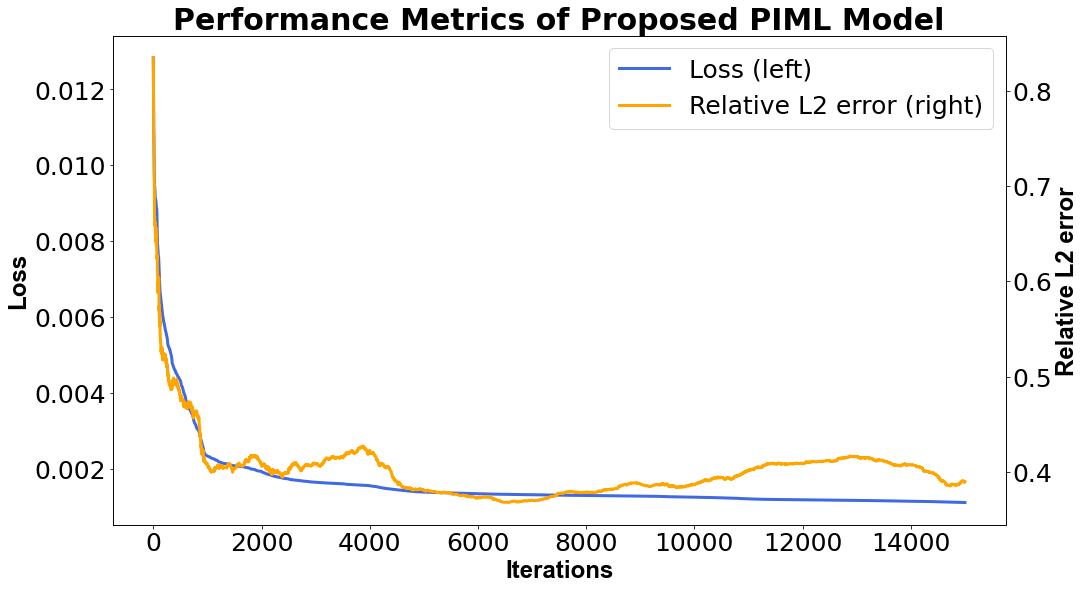

In [19]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [20]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.025099893884247187
MSE =  0.005837837823762175
RMSE =  0.07640574470393031
L2 relative error = 0.43671999806184897
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

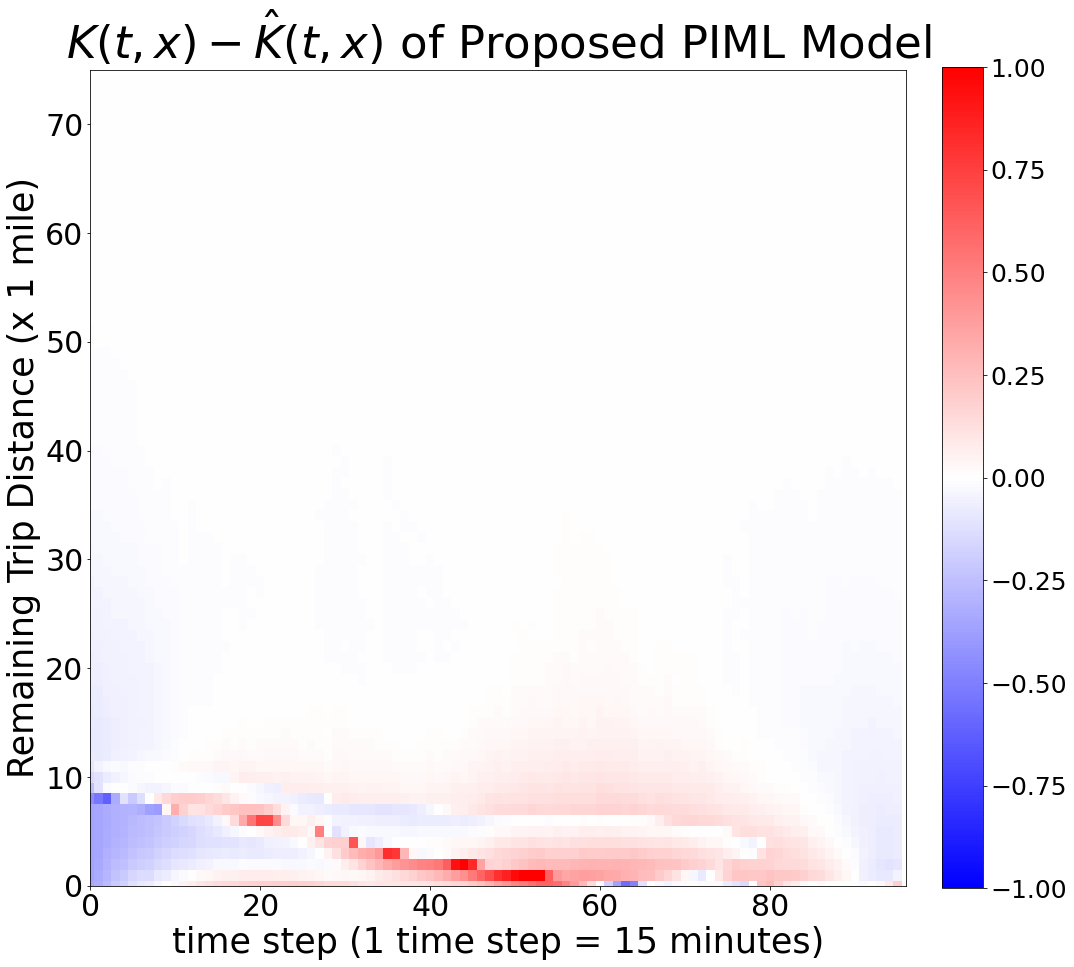

In [21]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,len(K_real),0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

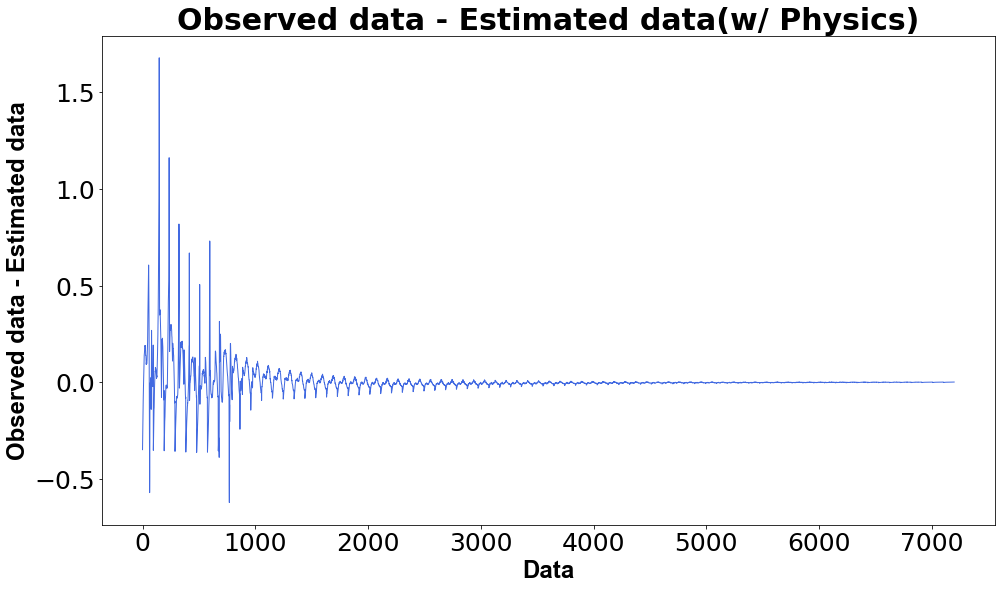

In [22]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

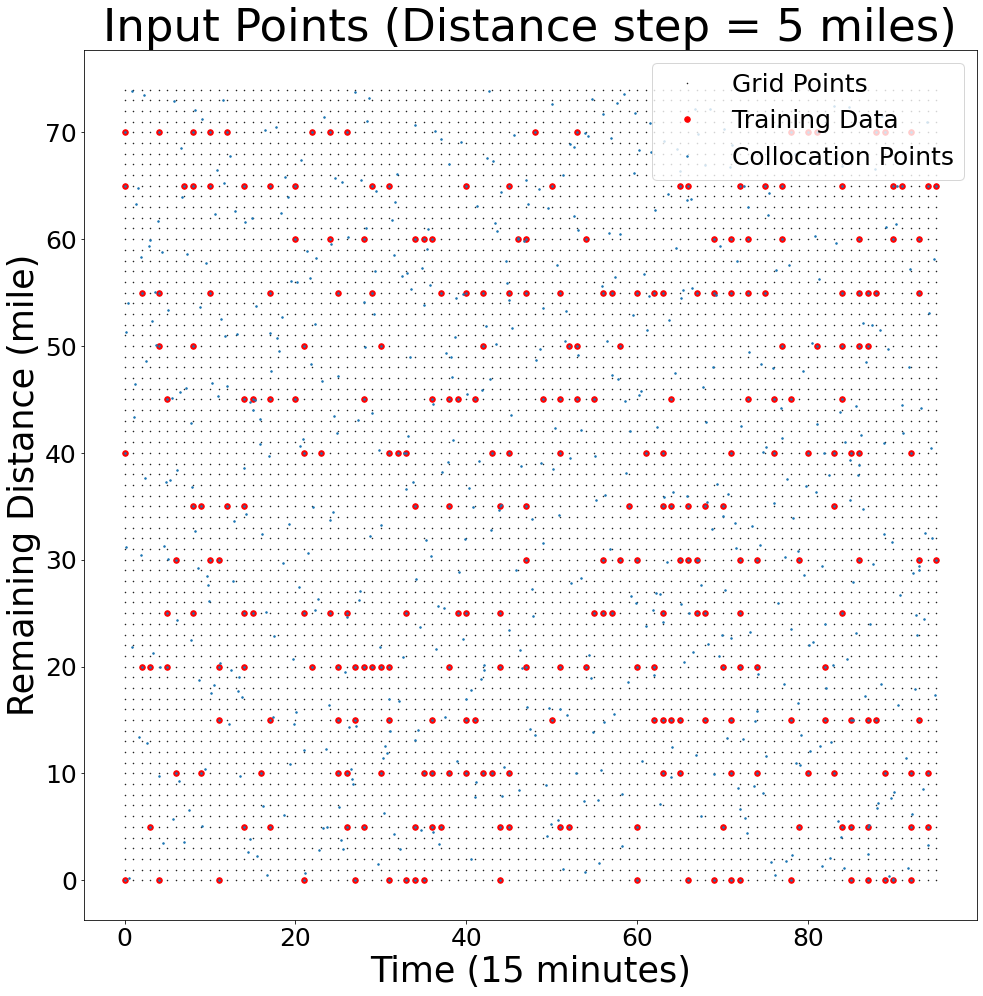

In [23]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

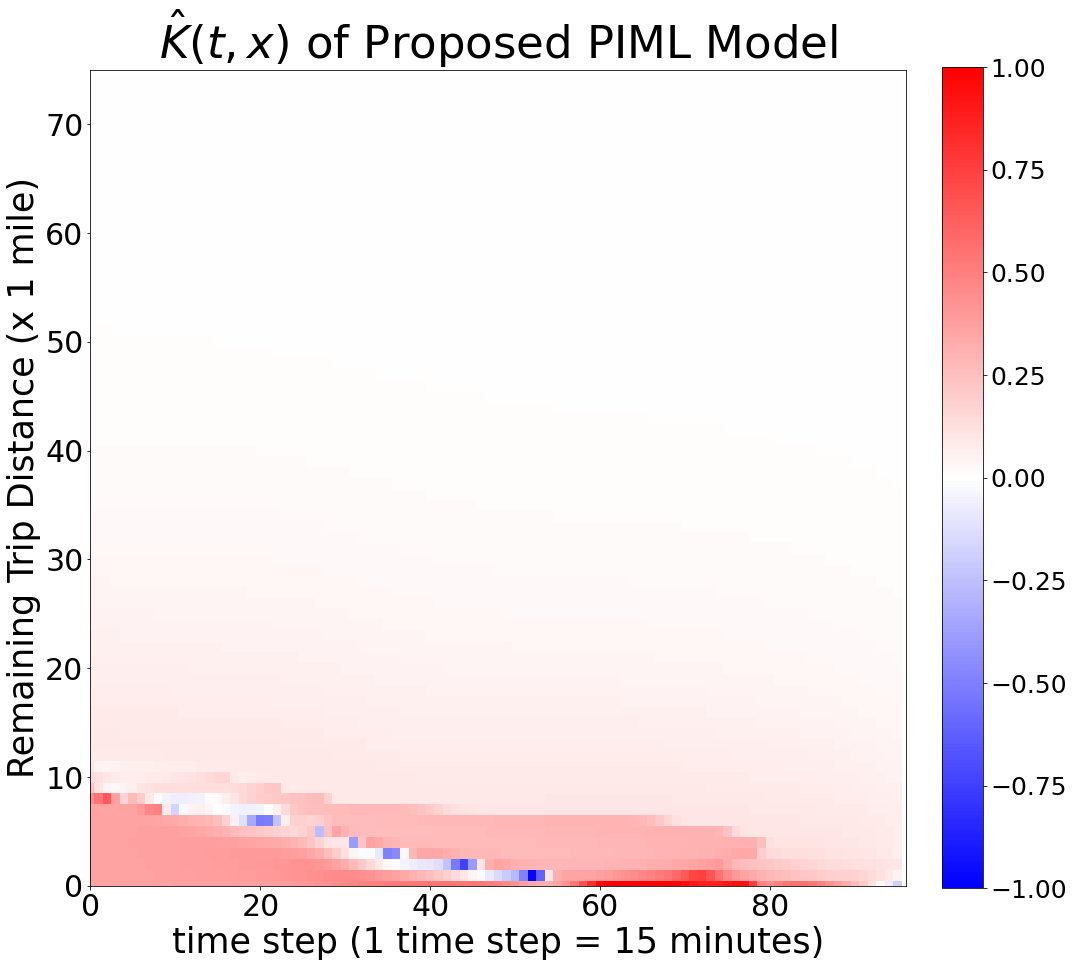

In [25]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,96,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)